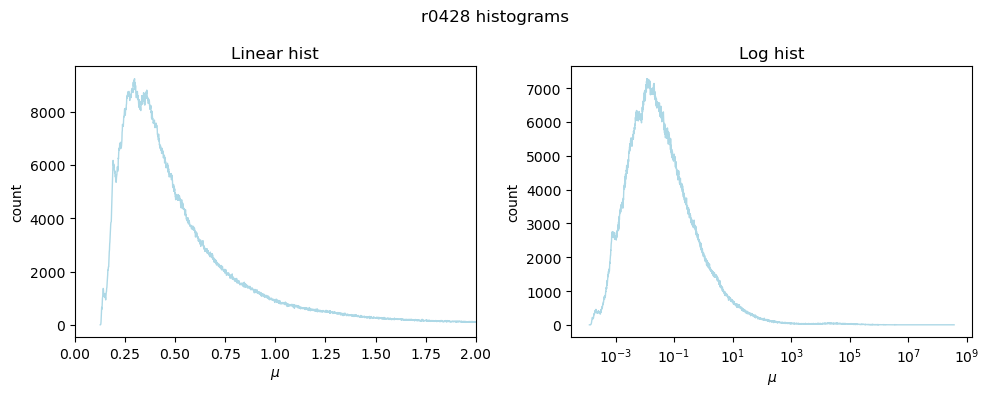

In [60]:
import numpy as np
import matplotlib.pyplot as plt

rid = "r0428"
npz_path = f"data_cache/hists/{rid}.npz"

data = np.load(npz_path)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 左边：linear
if "mu_linear" in data and "cnt_linear" in data:
    mu_lin = data["mu_linear"]
    cnt_lin = data["cnt_linear"]
    axes[0].plot(mu_lin, cnt_lin, "-", linewidth=1, color="lightblue")
    axes[0].set_xlim(0,2)
    axes[0].set_xlabel(r"$\mu$")
    axes[0].set_ylabel("count")
    axes[0].set_title("Linear hist")
else:
    axes[0].set_visible(False)

# 右边：log
if "mu_log" in data and "cnt_log" in data:
    mu_log = data["mu_log"]
    cnt_log = data["cnt_log"]
    axes[1].plot(mu_log, cnt_log, "-", linewidth=1, color="lightblue")
    axes[1].set_xscale("log")
    # axes[1].set_yscale("log")
    axes[1].set_xlabel(r"$\mu$")
    axes[1].set_ylabel("count")
    axes[1].set_title("Log hist")
else:
    axes[1].set_visible(False)

plt.suptitle(f"{rid} histograms")
plt.tight_layout()
plt.show()


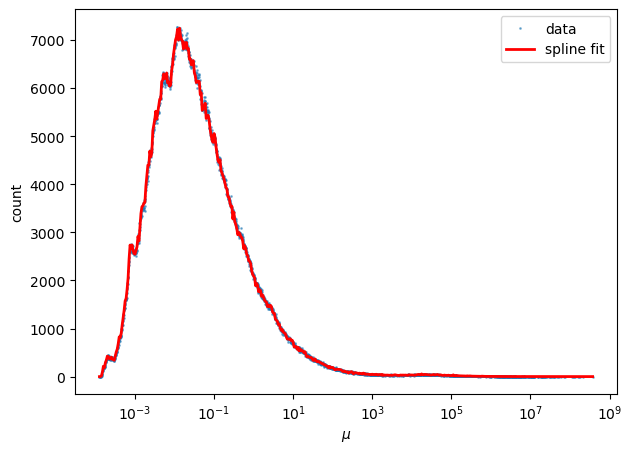

[(0.001, 2632.6267599694684), (0.01, 6617.010511881163), (0.1, 4901.829738248014), (1, 2043.936133805762), (10, 716.42805844207)]


In [62]:
import numpy as np
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt

# ===== 读取数据 =====
rid = "r0428"
npz_path = f"data_cache/hists/{rid}.npz"
data = np.load(npz_path)

mu_log = data["mu_log"]
cnt_log = data["cnt_log"]

# ===== 建立平滑器（在 log μ 空间插值） =====
log_mu = np.log(mu_log)
smoother = UnivariateSpline(log_mu, cnt_log, s=len(log_mu)*5)  # s 控制平滑度

# ===== 绘制拟合结果 =====
mu_grid = np.logspace(np.log10(mu_log.min()), np.log10(mu_log.max()), 500)
cnt_smooth = smoother(np.log(mu_grid))

plt.figure(figsize=(7,5))
plt.plot(mu_log, cnt_log, '.', ms=2, label='data', alpha=0.5)
plt.plot(mu_grid, cnt_smooth, 'r-', lw=2, label='spline fit')
plt.xscale('log')
plt.xlabel(r'$\mu$')
plt.ylabel('count')
plt.legend()
plt.show()

# ===== 定义平滑器接口 =====
def predict_count(mu_list):
    mu_arr = np.array(mu_list, dtype=float)
    return smoother(np.log(mu_arr))

# 测试：给新的 μ 值
test_mu = [1e-3, 1e-2, 1e-1, 1, 10]
print(list(zip(test_mu, predict_count(test_mu))))


success: True CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
alpha=1.342, mu0=0.00172, m(lnμ)=-3.278, s=2.378, w=0.529, N=4000000.1


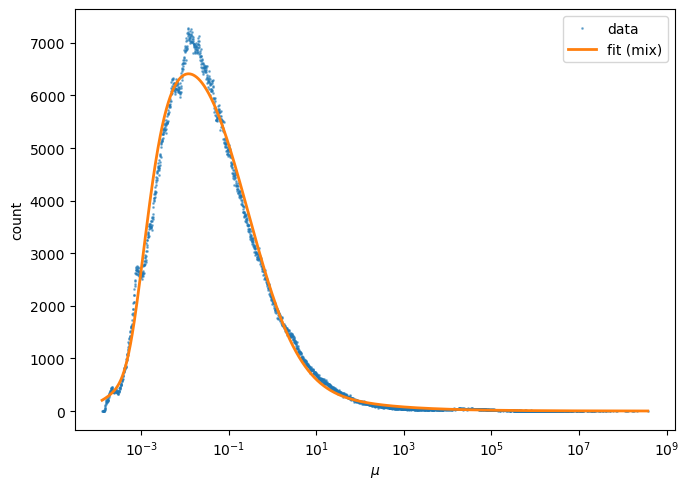

predict counts: [(0.001, 634327.29262011), (0.01, 1513179.2400365698), (0.1, 1191255.9255499714), (1, 518680.146466314), (10, 142557.4707427971)]
predict pdf: [(0.001, 15779.02325772768), (0.01, 3764.0648131385133), (0.1, 296.3273876726616), (1, 12.902276458274697), (10, 0.3546146717291849)]


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gammaln, logsumexp

# ===== 读取右图数据 =====
rid = "r0428"
data = np.load(f"data_cache/hists/{rid}.npz")
mu = data["mu_log"].astype(float)
cnt = data["cnt_log"].astype(float)

# 只保留有效数据
m = (mu > 0) & np.isfinite(cnt) & (cnt >= 0)
mu, cnt = mu[m], cnt[m]

# log-bin 宽度与每个 bin 的线性宽度
dL  = 0.01
dmu = mu * (np.exp(dL) - 1.0)
Ntot = cnt.sum()

# ===== 组件（连续密度的“形状”）=====
def shape_powerlaw_lowcut(mu, alpha, mu0):
    # 基底：μ^{-α} * exp(-mu0/μ)
    return np.power(mu, -alpha) * np.exp(-mu0/np.clip(mu,1e-300,None))

def shape_lognormal(mu, m, s):
    # 对数正态（完整密度形式）
    return np.exp(-0.5*((np.log(mu)-m)/s)**2) / (np.clip(mu,1e-300,None)*s*np.sqrt(2*np.pi))

def to_density(shape_vals, dmu_local):
    Z = np.sum(shape_vals * dmu_local)
    return shape_vals / max(Z, 1e-300)

# ===== 混合模型：w*lognormal + (1-w)*powerlaw_lowcut =====
def expected_counts(theta):
    # theta = [alpha, mu0, m, s, w_logit, logN]
    alpha, mu0, m, s, w_logit, logN = theta
    s = np.clip(s, 0.05, 3.0)                   # 合理范围
    w = 1.0 / (1.0 + np.exp(-w_logit))          # (0,1)
    Nscale = np.exp(logN)                       # 总幅度（计数尺度）

    p1 = to_density(shape_powerlaw_lowcut(mu, alpha, mu0), dmu)
    p2 = to_density(shape_lognormal(mu, m, s), dmu)
    pmix = w*p2 + (1-w)*p1

    lam = np.clip(Nscale * pmix * dmu, 1e-30, None)  # 期望计数
    return lam, (w, Nscale)

def nll(theta):
    lam, _ = expected_counts(theta)
    # Poisson 负对数似然
    return np.sum(lam - cnt*np.log(lam) + gammaln(cnt+1.0))

# ===== 初值与边界 =====
# 初值：主峰在 log μ ~ -3 到 -2 之间（按图微调）
alpha0, mu00 = 1.6, 1e-3
m0, s0 = -2.5, 0.8           # lognormal的中心与宽度（ln μ）
w0 = 0.2                      # 小峰权重（先给个非零）
logN0 = np.log(Ntot)          # 幅度以总计数为量级
wlogit0 = np.log(w0/(1-w0))

theta0 = np.array([alpha0, mu00, m0, s0, wlogit0, logN0], float)
bounds = [(0.5, 5.0),  (1e-5, 10.0),    # alpha, mu0
          (-12.0, 12.0), (0.05, 3.0),   # m=ln μ, s
          (-8.0, 8.0),   (np.log(1e-2), np.log(1e12))]   # w_logit, logN

res = minimize(nll, theta0, bounds=bounds, method="L-BFGS-B")
print("success:", res.success, res.message)
alpha, mu0, m, s, w_logit, logN = res.x
w = 1/(1+np.exp(-w_logit))
print(f"alpha={alpha:.3f}, mu0={mu0:.3g}, m(lnμ)={m:.3f}, s={s:.3f}, w={w:.3f}, N={np.exp(logN):.1f}")

lam_fit, _ = expected_counts(res.x)

# ===== 画图 =====
plt.figure(figsize=(7,5))
plt.plot(mu, cnt, '.', ms=2, alpha=0.5, label='data')
plt.plot(mu, lam_fit, '-', lw=2, label='fit (mix)')
plt.xscale('log')
plt.xlabel(r'$\mu$'); plt.ylabel('count'); plt.legend(); plt.tight_layout(); plt.show()

# ======= 预测接口：给新的 μ -> 期望计数（或概率密度） =======
def predict(mu_list, return_pdf=False):
    """返回拟合曲线值。
       return_pdf=False: 返回期望计数（与右图同量纲）
       return_pdf=True : 返回概率密度 p(μ)（归一化，∫p dμ = 1 的离散版本）
    """
    mu_new = np.asarray(mu_list, float)
    dmu_new = mu_new * (np.exp(dL) - 1.0)  # 若你的新μ也按同样log-bin，要这一行
    alpha, mu0, m, s, w_logit, logN = res.x
    w = 1/(1+np.exp(-w_logit))
    p1 = to_density(shape_powerlaw_lowcut(mu_new, alpha, mu0), dmu_new)
    p2 = to_density(shape_lognormal(mu_new, m, s), dmu_new)
    pmix = w*p2 + (1-w)*p1
    if return_pdf:
        return pmix
    else:
        Nscale = np.exp(logN)
        return Nscale * pmix * dmu_new

# 简单测试
test_mu = [1e-3, 1e-2, 1e-1, 1, 10]
print("predict counts:", list(zip(test_mu, predict(test_mu))))
print("predict pdf:", list(zip(test_mu, predict(test_mu, return_pdf=True))))


success: True
alpha=1.315, mu0=0.00125, m(lnμ)=-3.168, s=2.000, w=0.485, N=4000000.3


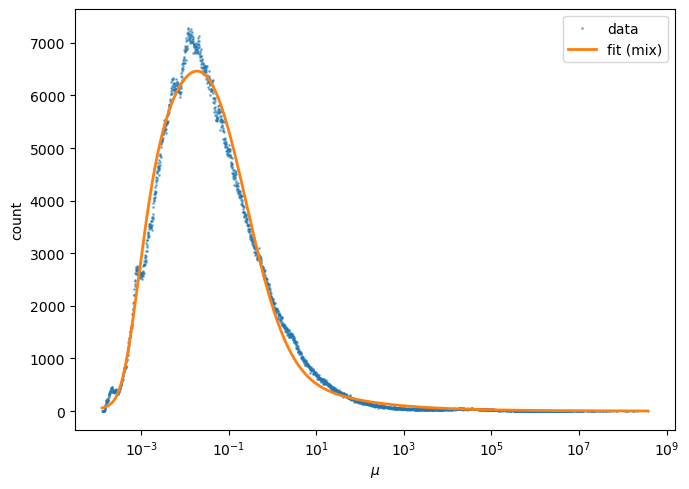

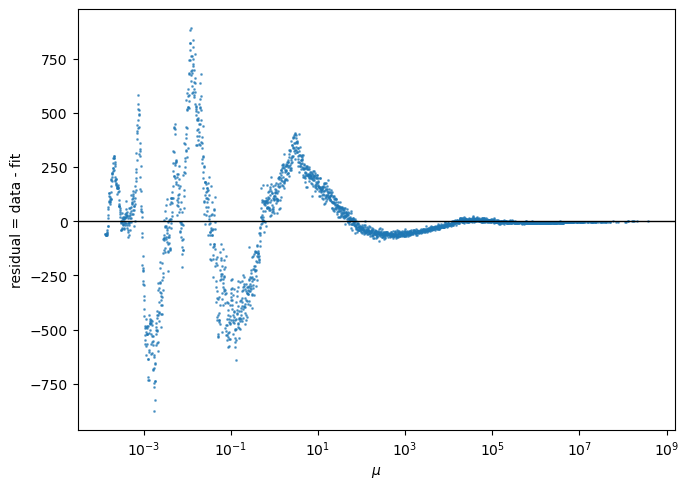

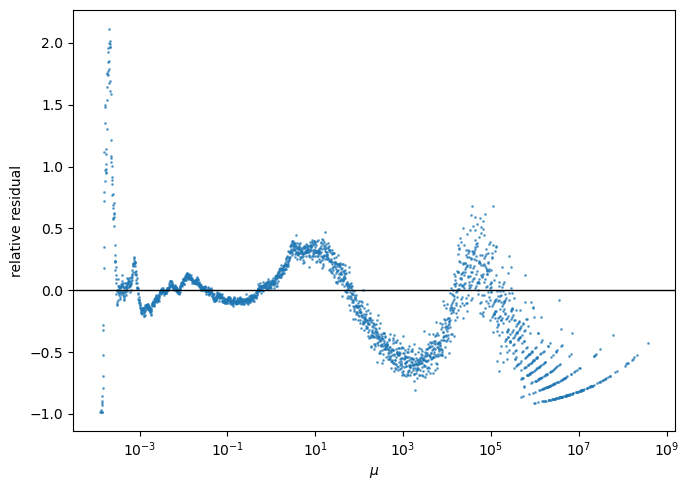

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gammaln

# ========= 读取右图数据 =========
rid = "r0428"
d = np.load(f"data_cache/hists/{rid}.npz")
mu  = d["mu_log"].astype(float)
cnt = d["cnt_log"].astype(float)

m = (mu > 0) & np.isfinite(cnt) & (cnt >= 0)
mu, cnt = mu[m], cnt[m]

# log-bin 宽度与每个 bin 的线性宽度
dL  = 0.01
dmu = mu * (np.exp(dL) - 1.0)
Ntot = cnt.sum()

# ========= 组件（连续密度形状）=========
def shape_powerlaw_lowcut(mu, alpha, mu0):
    # 基底：μ^{-α} * exp(-mu0/μ)
    return np.power(mu, -alpha) * np.exp(-mu0/np.clip(mu,1e-300,None))

def shape_lognormal(mu, m, s):
    # 对数正态（完整密度）
    return np.exp(-0.5*((np.log(mu)-m)/s)**2) / (np.clip(mu,1e-300,None)*s*np.sqrt(2*np.pi))

def to_density(shape_vals, dmu_local):
    Z = np.sum(shape_vals * dmu_local)
    return shape_vals / max(Z, 1e-300)

# ========= 混合模型：w*lognormal + (1-w)*powerlaw_lowcut =========
def expected_counts(theta, mu=mu, dmu=dmu):
    # theta = [alpha, mu0, m, s, w_logit, logN]
    alpha, mu0, m, s, w_logit, logN = theta
    s = np.clip(s, 0.05, 2.0)
    w = 1.0 / (1.0 + np.exp(-w_logit))  # (0,1)
    Nscale = np.exp(logN)

    p_base = to_density(shape_powerlaw_lowcut(mu, alpha, mu0), dmu)
    p_bump = to_density(shape_lognormal(mu, m, s), dmu)
    pmix   = (1-w)*p_base + w*p_bump

    lam = np.clip(Nscale * pmix * dmu, 1e-30, None)  # 期望计数
    return lam

def nll(theta):
    lam = expected_counts(theta)
    return np.sum(lam - cnt*np.log(lam) + gammaln(cnt+1.0))

# ========= 拟合 =========
alpha0, mu00 = 1.6, 1e-3
m0, s0       = -2.5, 0.8
w0           = 0.2
logN0        = np.log(Ntot)
wlogit0      = np.log(w0/(1-w0))

theta0 = np.array([alpha0, mu00, m0, s0, wlogit0, logN0], float)
bounds = [(0.5, 5.0), (1e-5, 10.0),   # alpha, mu0
          (-12.0, 12.0), (0.05, 2.0), # m=lnμ, s
          (-8.0,  8.0),  (np.log(1e-2), np.log(1e12))]  # w_logit, logN

res = minimize(nll, theta0, bounds=bounds, method="L-BFGS-B")
alpha, mu0, m, s, w_logit, logN = res.x
w = 1/(1+np.exp(-w_logit))
lam_fit = expected_counts(res.x)

print("success:", res.success)
print(f"alpha={alpha:.3f}, mu0={mu0:.3g}, m(lnμ)={m:.3f}, s={s:.3f}, w={w:.3f}, N={np.exp(logN):.1f}")

# ========= 画拟合与残差 =========
# 1) 拟合曲线
plt.figure(figsize=(7,5))
plt.plot(mu, cnt, '.', ms=2, alpha=0.5, label='data')
plt.plot(mu, lam_fit, '-', lw=2, label='fit (mix)')
plt.xscale('log')
plt.xlabel(r'$\mu$'); plt.ylabel('count'); plt.legend(); plt.tight_layout(); plt.show()

# 2) 绝对残差：data - fit
res_abs = cnt - lam_fit
plt.figure(figsize=(7,5))
plt.plot(mu, res_abs, '.', ms=2, alpha=0.6)
plt.axhline(0, color='k', lw=1)
plt.xscale('log')
plt.xlabel(r'$\mu$'); plt.ylabel('residual = data - fit'); plt.tight_layout(); plt.show()

# 3) 相对残差：(data - fit)/fit
res_rel = res_abs / np.clip(lam_fit, 1e-12, None)
plt.figure(figsize=(7,5))
plt.plot(mu, res_rel, '.', ms=2, alpha=0.6)
plt.axhline(0, color='k', lw=1)
plt.xscale('log')
plt.xlabel(r'$\mu$'); plt.ylabel('relative residual'); plt.tight_layout(); plt.show()


success: True CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
weights(base, bump[, flat]) = [9.94448681e-01 5.21769320e-03 3.33625819e-04]
params = [9.04621089e-01 1.32383177e+00 2.23654109e-02 6.97293935e-04
 1.00776971e+02 8.00000000e-01 9.15724520e+00 1.20000000e+00
 3.38702001e-03 7.99992371e+00 2.74979060e+00 1.52195161e+01]


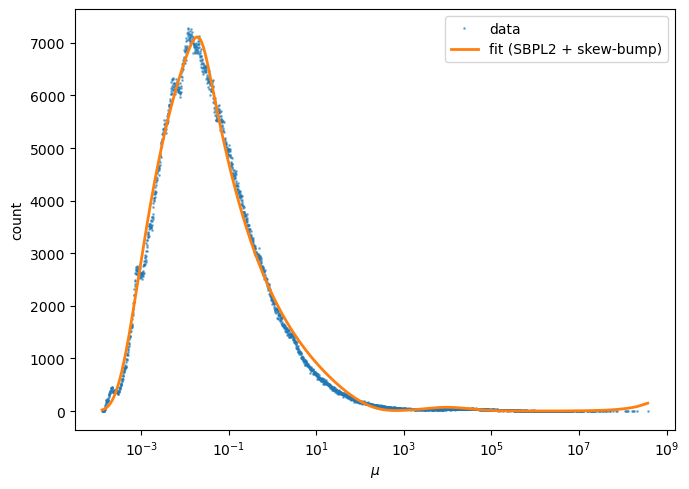

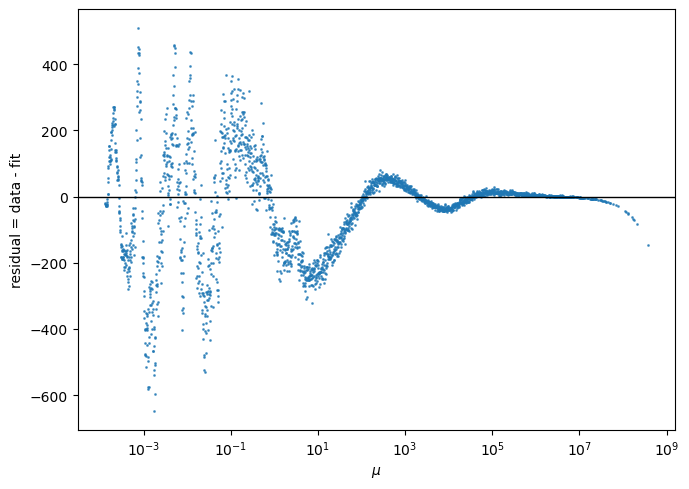

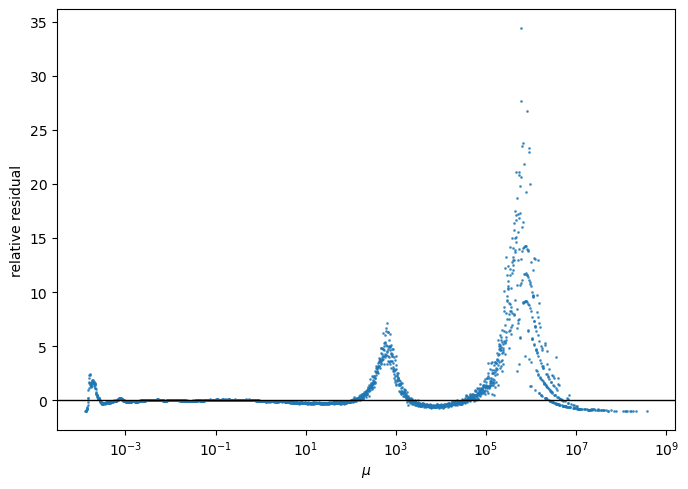

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gammaln, erf, logsumexp

# ========= 配置 =========
RID = "r0428"
NPZ = f"data_cache/hists/{RID}.npz"
dL = 0.01  # log-bin 宽度（你的数据是等宽 lnμ bin）
USE_FLAT = True

# 峰区加权（让主峰更准），尾部降权（防止尾巴拖模型）
PEAK_RANGE = (2e-3, 2e-1)
PEAK_W = 8.0
TAIL_RANGE = (1.0, 1e9)
TAIL_W = 0.7

# ========= 读取右图数据 =========
d = np.load(NPZ)
mu  = d["mu_log"].astype(float)
cnt = d["cnt_log"].astype(float)

m = (mu > 0) & np.isfinite(cnt) & (cnt >= 0)
mu, cnt = mu[m], cnt[m]
dmu = mu * (np.exp(dL) - 1.0)   # 每个bin的线性宽度
Ntot = cnt.sum()

# ========= 形状函数 =========
def shape_sbpl2(mu, a_low, a_high, mub, q, mu0, muc, kt):
    """ 双斜率SBPL × 低端截断 × 高端截断 """
    mu = np.clip(mu, 1e-300, None)
    base = mu**(-a_low)
    br   = (1.0 + (mu/np.clip(mub,1e-30,None))**q) ** (-(a_high - a_low)/q)
    low  = np.exp(-mu0 / mu)
    high = np.exp(- (mu/np.clip(muc,1e-30,None))**np.clip(kt, 0.5, 8.0))
    return base * br * low * high

def shape_log_skew_normal(mu, m, s, skew):
    """
    对数偏态正态（log-skew-normal）：
    p(μ) ∝ (2/μ) φ(z) Φ(skew * z),  z = (ln μ - m)/s
    其中 φ 为标准正态密度，Φ 为标准正态CDF。
    """
    mu = np.clip(mu, 1e-300, None)
    z = (np.log(mu) - m) / np.clip(s, 1e-9, None)
    phi = np.exp(-0.5*z*z) / np.sqrt(2*np.pi)
    Phi = 0.5*(1.0 + erf(skew * z / np.sqrt(2.0)))
    return 2.0 * phi * Phi / mu / np.clip(s, 1e-9, None)

def shape_flat(mu):
    return np.ones_like(mu)

def to_density(shape_vals, dmu_local):
    Z = np.sum(shape_vals * dmu_local)
    return shape_vals / max(Z, 1e-300)

# ========= 混合模型：SBPL2 + skew-bump (+ flat) =========
def expected_counts(theta, mu_arr=mu, dmu_arr=dmu):
    """
    theta = [a_low, a_high, mub, mu0, muc, kt,   m, s, skew,   u_base, u_bump, logN]
    若 USE_FLAT=True：再隐含一个 u_flat=0 进入 softmax。
    """
    a_low, a_high, mub, mu0, muc, kt, m_b, s_b, skew_b, u1, u2, logN = theta
    q = 5.0  # SBPL平滑参数，固定即可
    s_b   = np.clip(s_b,   0.05, 1.5)
    skew_b = np.clip(skew_b, -10.0, 10.0)

    p_base = to_density(shape_sbpl2(mu_arr, a_low, a_high, mub, q, mu0, muc, kt), dmu_arr)
    p_bump = to_density(shape_log_skew_normal(mu_arr, m_b, s_b, skew_b), dmu_arr)
    comps = [p_base, p_bump]
    u = np.array([u1, u2])

    if USE_FLAT:
        p_flat = to_density(shape_flat(mu_arr), dmu_arr)
        comps.append(p_flat)
        u = np.array([u1, u2, 0.0])

    w = np.exp(u - logsumexp(u))
    pmix = np.zeros_like(mu_arr)
    for wi, pi in zip(w, comps):
        pmix += wi * pi

    Nscale = np.exp(logN)
    lam = np.clip(Nscale * pmix * dmu_arr, 1e-30, None)
    return lam, w

# ========= 加权 Poisson NLL =========
weights = np.ones_like(mu, float)
weights[(mu >= PEAK_RANGE[0]) & (mu <= PEAK_RANGE[1])] *= PEAK_W
weights[(mu >= TAIL_RANGE[0]) & (mu <= TAIL_RANGE[1])] *= TAIL_W

def nll(theta):
    lam, _ = expected_counts(theta)
    return np.sum(weights * (lam - cnt*np.log(lam) + gammaln(cnt + 1.0)))

# ========= 初值 & 边界 =========
# 峰位在 1e-3~1e-1 之间，低端很陡，高端要有指数截断
theta0 = [
    0.6,  2.2,   5e-3,  1e-3,   50.0,  2.5,    # a_low, a_high, mub, mu0, muc, kt
   -2.7,  0.35,  2.5,                         # bump: m, s, skew
    2.0,  0.0,   np.log(max(Ntot,1.0))        # u_base, u_bump, logN
]
bounds = [
    (0.1, 3.0),  (0.8, 6.0),   (1e-4, 1.0),  (1e-5, 1e-1), (1e-1, 1e4), (0.8, 6.0),
    (-12, 12),   (0.05, 1.2),  (-8.0, 8.0),
    (-8, 8),     (-8, 8),
    (np.log(1e-2), np.log(1e12))
]

res = minimize(nll, np.array(theta0, float), bounds=bounds, method="L-BFGS-B")
print("success:", res.success, res.message)
lam_fit, w = expected_counts(res.x)
print("weights(base, bump[, flat]) =", w)
print("params =", res.x)

# ========= 画拟合 =========
plt.figure(figsize=(7,5))
plt.plot(mu, cnt, '.', ms=2, alpha=0.5, label='data')
plt.plot(mu, lam_fit, '-', lw=2, label='fit (SBPL2 + skew-bump)')
plt.xscale('log')
plt.xlabel(r'$\mu$'); plt.ylabel('count'); plt.legend(); plt.tight_layout(); plt.show()

# ========= 残差 =========
res_abs = cnt - lam_fit
res_rel = res_abs / np.clip(lam_fit, 1e-12, None)

plt.figure(figsize=(7,5))
plt.plot(mu, res_abs, '.', ms=2, alpha=0.7)
plt.axhline(0, color='k', lw=1)
plt.xscale('log')
plt.xlabel(r'$\mu$'); plt.ylabel('residual = data - fit')
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
plt.plot(mu, res_rel, '.', ms=2, alpha=0.7)
plt.axhline(0, color='k', lw=1)
plt.xscale('log')
plt.xlabel(r'$\mu$'); plt.ylabel('relative residual')
plt.tight_layout(); plt.show()

# ========= 可选：预测接口 =========
def predict(mu_list, return_pdf=False):
    mu_new = np.asarray(mu_list, float)
    dmu_new = mu_new * (np.exp(dL) - 1.0)
    lam_new, w_new = expected_counts(res.x, mu_arr=mu_new, dmu_arr=dmu_new)
    if return_pdf:
        # 返回离散密度（和为1），便于 logμ-prob 用途
        Nscale = np.exp(res.x[-1])
        return np.clip(lam_new / (Nscale * dmu_new), 0, None)
    return lam_new


success: True CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
weights (base, [bump1], [bump2], [flat]) = [9.97606113e-01 8.09449184e-07 2.39307706e-03]
params = [ 8.46911791e-01  1.51320821e+00  5.56237057e-02  5.75336750e-04
  1.00000000e+04  3.92014015e+00  9.46677452e+00  1.19968337e+00
  2.02494887e+00  6.03277851e+00 -7.99173657e+00  1.52567560e+01]


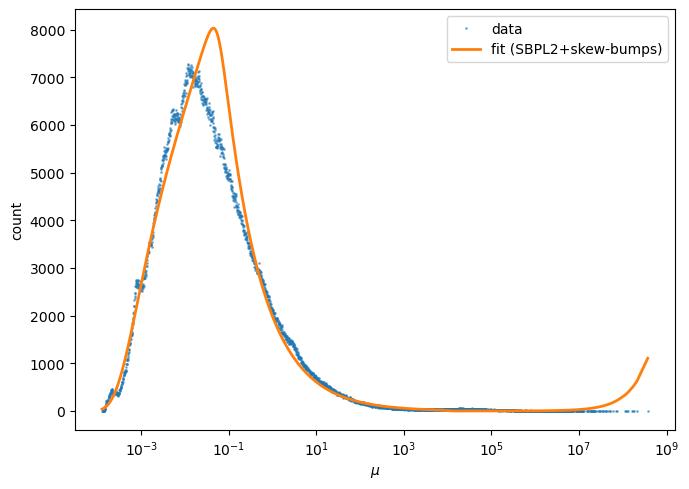

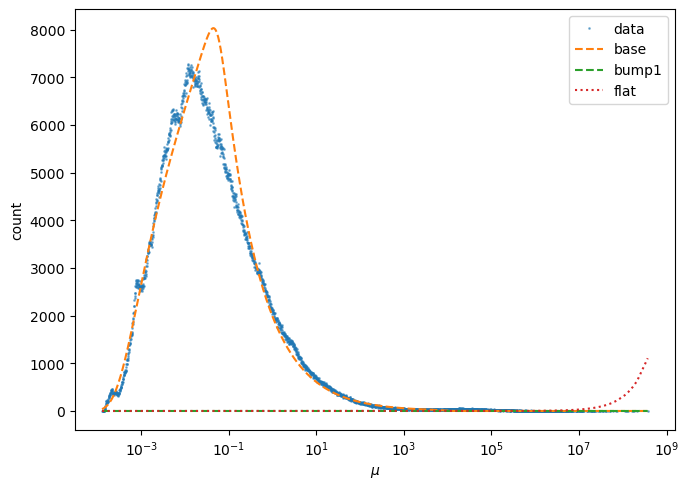

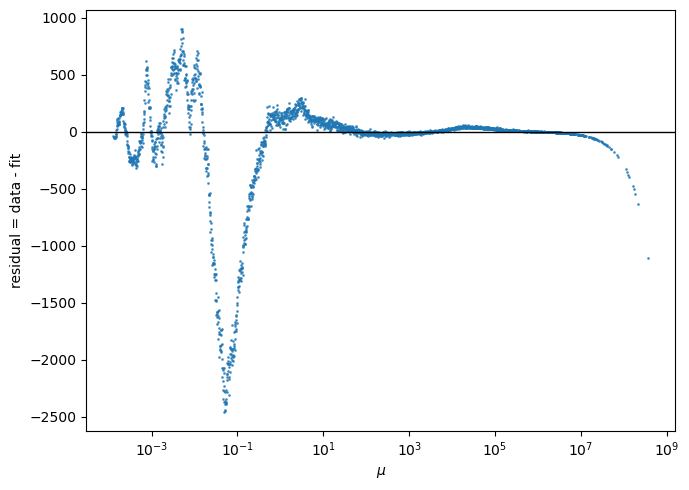

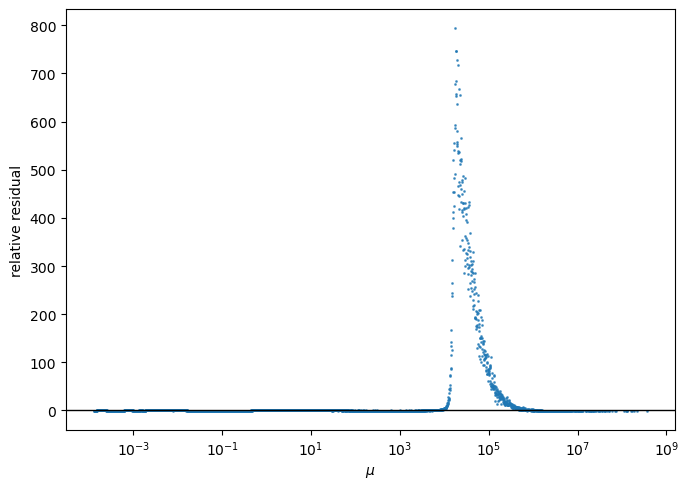

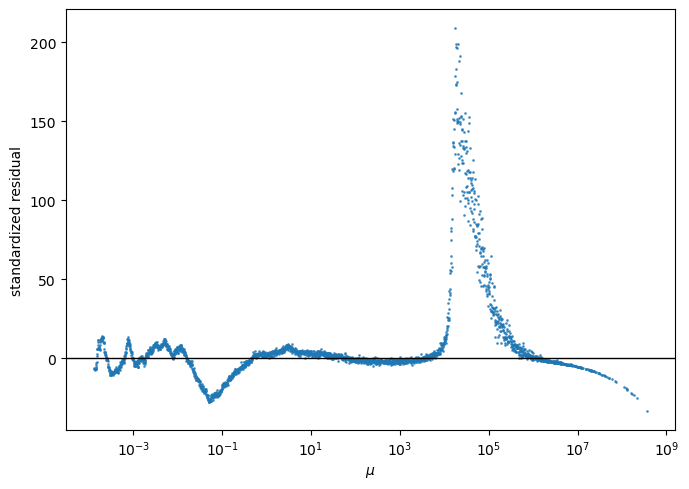

In [81]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gammaln, erf, logsumexp

# ========== 配置 ==========
RID = "r0428"
NPZ = f"data_cache/hists/{RID}.npz"

dL = 0.01                 # 你的 log-bin 步长
USE_BUMP1 = True          # 主峰 bump
USE_BUMP2 = False          # 次峰 bump（解决 μ≈10^2–10^3 的正残差）
USE_FLAT  = True          # 平坦地板

# 加权：主峰↑，次峰↑，低μ↓，尾部↓（按需调参）
PEAK_RANGE = (2e-3, 2e-1); PEAK_W = 10.0
MID_RANGE  = (1e2, 1e4) ;  MID_W  =  6.0
LOW_RANGE  = (1e-5, 5e-4); LOW_W  =  0.5
TAIL_RANGE = (1.0, 1e9) ;  TAIL_W =  0.7

PLOT_COMPONENTS = True    # 是否画出各分量曲线

# ========== 读取右图数据 ==========
d = np.load(NPZ)
mu  = d["mu_log"].astype(float)
cnt = d["cnt_log"].astype(float)

mvalid = (mu > 0) & np.isfinite(cnt) & (cnt >= 0)
mu  = mu[mvalid]
cnt = cnt[mvalid]
dmu = mu * (np.exp(dL) - 1.0)    # 每个 log-bin 的线性宽度
Ntot = cnt.sum()

# ========== 形状函数 ==========
def shape_sbpl2(mu, a_low, a_high, mub, q, mu0, muc, kt):
    """双斜率 SBPL × 低端截断 × 高端截断"""
    mu = np.clip(mu, 1e-300, None)
    base = mu**(-a_low)
    br   = (1.0 + (mu/np.clip(mub,1e-30,None))**q) ** (-(a_high - a_low)/q)
    low  = np.exp(-mu0 / mu)
    high = np.exp(- (mu/np.clip(muc,1e-30,None))**np.clip(kt, 0.5, 8.0))
    return base * br * low * high

def shape_log_skew_normal(mu, m, s, skew):
    """
    对数偏态正态： p(μ) ∝ (2/μ) φ(z) Φ(skew*z), z=(ln μ - m)/s
    s 控制宽度，skew 控制不对称（>0 右偏，<0 左偏）
    """
    mu = np.clip(mu, 1e-300, None)
    s  = np.clip(s, 1e-9, None)
    z  = (np.log(mu) - m) / s
    phi = np.exp(-0.5*z*z) / np.sqrt(2*np.pi)
    Phi = 0.5 * (1.0 + erf(skew * z / np.sqrt(2.0)))
    return 2.0 * phi * Phi / (mu * s)

def shape_flat(mu):
    return np.ones_like(mu)

def to_density(shape_vals, dmu_local):
    """离散归一：∑ p_i Δμ_i = 1"""
    Z = np.sum(shape_vals * dmu_local)
    return shape_vals / max(Z, 1e-300)

# ========== 期望计数（混合） ==========
def expected_counts(theta, mu_arr=mu, dmu_arr=dmu):
    """
    参数顺序：
    base:   a_low, a_high, mub, mu0, muc, kt
    bump1:  m1, s1, skew1             [若 USE_BUMP1]
    bump2:  m2, s2, skew2             [若 USE_BUMP2]
    logits: u_base, u_b1, u_b2        [按启用情况截取]
    scale:  logN
    """
    idx = 0
    a_low, a_high, mub, mu0, muc, kt = theta[idx:idx+6]; idx += 6
    q = 5.0  # SBPL 平滑参数（固定即可）

    p_base = to_density(shape_sbpl2(mu_arr, a_low, a_high, mub, q, mu0, muc, kt), dmu_arr)
    comps = [p_base]
    ulist = []

    if USE_BUMP1:
        m1, s1, sk1 = theta[idx:idx+3]; idx += 3
        s1 = np.clip(s1, 0.05, 1.2)
        p_b1 = to_density(shape_log_skew_normal(mu_arr, m1, s1, sk1), dmu_arr)
        comps.append(p_b1)

    if USE_BUMP2:
        m2, s2, sk2 = theta[idx:idx+3]; idx += 3
        s2 = np.clip(s2, 0.05, 1.2)
        p_b2 = to_density(shape_log_skew_normal(mu_arr, m2, s2, sk2), dmu_arr)
        comps.append(p_b2)

    # 权重 logits
    u_base = theta[idx]; idx += 1
    ulist.append(u_base)
    if USE_BUMP1: 
        u_b1 = theta[idx]; idx += 1; ulist.append(u_b1)
    if USE_BUMP2: 
        u_b2 = theta[idx]; idx += 1; ulist.append(u_b2)

    # flat 分量
    if USE_FLAT:
        p_flat = to_density(shape_flat(mu_arr), dmu_arr)
        comps.append(p_flat)
        ulist.append(0.0)  # 参考基准

    u = np.array(ulist, float)
    w = np.exp(u - logsumexp(u))  # softmax

    pmix = np.zeros_like(mu_arr)
    for wi, pi in zip(w, comps):
        pmix += wi * pi

    logN = theta[idx]
    Nscale = np.exp(logN)
    lam = np.clip(Nscale * pmix * dmu_arr, 1e-30, None)
    return lam, w

# ========== 加权 Poisson NLL ==========
# ===== 2) 拟合时剔除主峰区间 =====
# 替换/追加这段权重设置（注意把原来的 PEAK_W 提升去掉）
weights = np.ones_like(mu, float)

# 主峰区间：不参与拟合（权重=0）
PEAK_RANGE = (2e-3, 2e-1)
weights[(mu >= PEAK_RANGE[0]) & (mu <= PEAK_RANGE[1])] = 0.0

# 其他区间按需加权（可保留/微调）
MID_RANGE  = (1e2, 1e4);  MID_W  = 6.0
LOW_RANGE  = (1e-5, 5e-4); LOW_W  = 0.5
TAIL_RANGE = (1.0, 1e9);   TAIL_W = 0.7

weights[(mu>=MID_RANGE[0])  & (mu<=MID_RANGE[1])]  *= MID_W
weights[(mu>=LOW_RANGE[0])  & (mu<=LOW_RANGE[1])]  *= LOW_W
weights[(mu>=TAIL_RANGE[0]) & (mu<=TAIL_RANGE[1])] *= TAIL_W


def nll(theta):
    lam, _ = expected_counts(theta)
    # Poisson 负对数似然 + 加权
    return np.sum(weights * (lam - cnt*np.log(lam) + gammaln(cnt + 1.0)))

# ========== 初值与边界 ==========
theta0 = [
    # base: a_low, a_high, mub, mu0, muc, kt
     0.6,    2.2,   5e-3,  1e-3,  50.0, 2.5,
]
bounds = [
    (0.1,3.0), (0.8,6.0), (1e-4,1.0), (1e-5,1e-1), (1e-1,1e4), (0.8,6.0),
]

if USE_BUMP1:
    # 主峰（ln μ ~ -3~-2）
    theta0 += [-2.7, 0.35, 2.0]                    # m1, s1, skew1
    bounds += [(-12,12), (0.05,1.2), (-8.0,8.0)]

if USE_BUMP2:
    # 次峰（锁在 μ≈10^2–10^4，可按残差调窄/放宽）
    theta0 += [np.log(5e2), 0.5, 0.0]              # m2, s2, skew2
    bounds += [(np.log(1e2), np.log(1e4)), (0.05,1.2), (-8.0,8.0)]

# 权重 logits（按启用顺序：base, bump1, bump2[, flat固定为0]）
theta0 += [2.0] + ([0.0] if USE_BUMP1 else []) + ([0.0] if USE_BUMP2 else [])
bounds += [(-8,8)] + ( [(-8,8)] if USE_BUMP1 else [] ) + ( [(-8,8)] if USE_BUMP2 else [] )

# 幅度
theta0 += [np.log(max(Ntot,1.0))]
bounds += [(np.log(1e-2), np.log(1e12))]

theta0 = np.array(theta0, float)

# ========== 拟合 ==========
res = minimize(nll, theta0, bounds=bounds, method="L-BFGS-B")
print("success:", res.success, res.message)
lam_fit, w = expected_counts(res.x)
print("weights (base, [bump1], [bump2], [flat]) =", w)
print("params =", res.x)

# ========== 可视化：拟合 ==========
plt.figure(figsize=(7,5))
plt.plot(mu, cnt, '.', ms=2, alpha=0.5, label='data')
plt.plot(mu, lam_fit, '-', lw=2, label='fit (SBPL2+skew-bumps)')
plt.xscale('log')
plt.xlabel(r'$\mu$'); plt.ylabel('count'); plt.legend(); plt.tight_layout(); plt.show()

# ========== 可视化：各分量（可选） ==========
if PLOT_COMPONENTS:
    def comp_curves(theta):
        idx = 0
        a_low, a_high, mub, mu0, muc, kt = theta[idx:idx+6]; idx += 6
        q = 5.0
        p_base = to_density(shape_sbpl2(mu, a_low,a_high,mub,q,mu0,muc,kt), dmu)
        comps = [p_base]; labels = ['base']
        if USE_BUMP1:
            m1,s1,sk1 = theta[idx:idx+3]; idx += 3
            p_b1 = to_density(shape_log_skew_normal(mu, m1,s1,sk1), dmu)
            comps.append(p_b1); labels.append('bump1')
        if USE_BUMP2:
            m2,s2,sk2 = theta[idx:idx+3]; idx += 3
            p_b2 = to_density(shape_log_skew_normal(mu, m2,s2,sk2), dmu)
            comps.append(p_b2); labels.append('bump2')
        ulist = [theta[idx]]; idx += 1
        if USE_BUMP1: ulist.append(theta[idx]); idx += 1
        if USE_BUMP2: ulist.append(theta[idx]); idx += 1
        if USE_FLAT:
            p_flat = to_density(shape_flat(mu), dmu)
            comps.append(p_flat); labels.append('flat')
            ulist.append(0.0)
        w = np.exp(np.array(ulist) - logsumexp(np.array(ulist)))
        Nscale = np.exp(theta[-1])
        curves = [Nscale * wi * pi * dmu for wi,pi in zip(w, comps)]
        return labels, curves

    labs, curves = comp_curves(res.x)
    plt.figure(figsize=(7,5))
    plt.plot(mu, cnt, '.', ms=2, alpha=0.5, label='data')
    for lab, c in zip(labs, curves):
        ls = '--' if lab != 'flat' else ':'
        plt.plot(mu, c, ls=ls, label=lab)
    plt.xscale('log'); plt.xlabel(r'$\mu$'); plt.ylabel('count'); plt.legend(); plt.tight_layout(); plt.show()

# ========== 残差（绝对/相对/标准化） ==========
res_abs = cnt - lam_fit
res_rel = res_abs / np.clip(lam_fit, 1e-12, None)
res_std = res_abs / np.sqrt(np.clip(lam_fit, 1e-12, None))  # ≈Pearson 残差

plt.figure(figsize=(7,5))
plt.plot(mu, res_abs, '.', ms=2, alpha=0.7)
plt.axhline(0, color='k', lw=1)
plt.xscale('log')
plt.xlabel(r'$\mu$'); plt.ylabel('residual = data - fit')
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
plt.plot(mu, res_rel, '.', ms=2, alpha=0.7)
plt.axhline(0, color='k', lw=1)
plt.xscale('log')
plt.xlabel(r'$\mu$'); plt.ylabel('relative residual')
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,5))
plt.plot(mu, res_std, '.', ms=2, alpha=0.7)
plt.axhline(0, color='k', lw=1)
plt.xscale('log')
plt.xlabel(r'$\mu$'); plt.ylabel('standardized residual')
plt.tight_layout(); plt.show()

# ========== 预测接口 ==========
def predict(mu_list, return_pdf=False):
    """return_pdf=False: 期望计数；True: 概率密度（离散归一）"""
    mu_new = np.asarray(mu_list, float)
    dmu_new = mu_new * (np.exp(dL) - 1.0)
    lam_new, w_new = expected_counts(res.x, mu_arr=mu_new, dmu_arr=dmu_new)
    if return_pdf:
        Nscale = np.exp(res.x[-1])
        return np.clip(lam_new / (Nscale * dmu_new), 0, None)
    return lam_new


[mask spike] i0=2390, width≈0.05 bins, mu∈[3.42e+06,3.67e+06]
success: True CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
weights (base, [bump1], [bump2], [flat]) = [0.94761664 0.05125628 0.00112708]
params = [ 8.65606106e-01  1.42468227e+00  2.44434965e-02  6.29429957e-04
  5.92499617e+03  8.00000000e-01 -1.81352311e-01  1.20000000e+00
 -3.50951840e-01  6.73432063e+00  3.81720870e+00  1.52005928e+01]


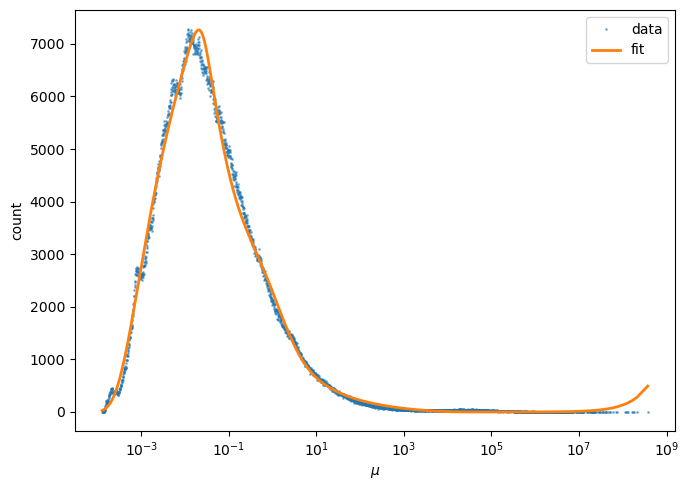

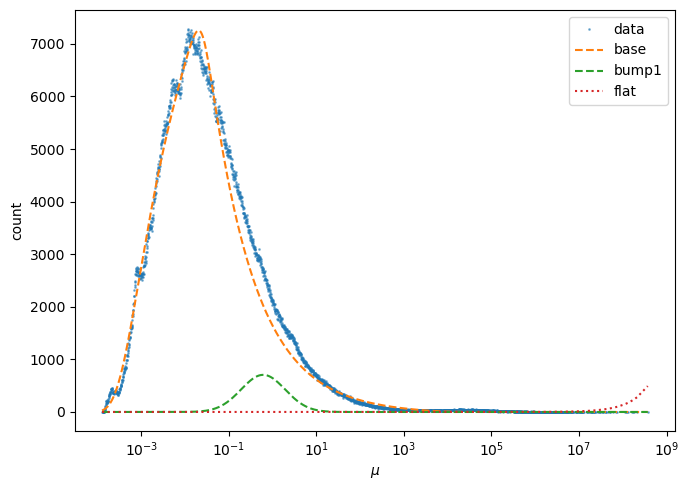

In [92]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gammaln, erf, logsumexp
from scipy.signal import find_peaks, peak_widths
from scipy.ndimage import median_filter

# ========== 配置 ==========
RID = "r0428"
NPZ = f"data_cache/hists/{RID}.npz"

dL = 0.01                 # log-bin 步长
USE_BUMP1 = True          # 主峰 bump
USE_BUMP2 = False         # 次峰 bump
USE_FLAT  = True          # 平坦地板
PLOT_COMPONENTS = True    # 是否画出各分量曲线

# ========== 读取数据 ==========
d = np.load(NPZ)
mu  = d["mu_log"].astype(float)
cnt = d["cnt_log"].astype(float)

mvalid = (mu > 0) & np.isfinite(cnt) & (cnt >= 0)
mu  = mu[mvalid]
cnt = cnt[mvalid]
dmu = mu * (np.exp(dL) - 1.0)    # 每个 log-bin 的线性宽度
Ntot = cnt.sum()

# ========== 形状函数 ==========
def shape_sbpl2(mu, a_low, a_high, mub, q, mu0, muc, kt):
    mu = np.clip(mu, 1e-300, None)
    base = mu**(-a_low)
    br   = (1.0 + (mu/np.clip(mub,1e-30,None))**q) ** (-(a_high - a_low)/q)
    low  = np.exp(-mu0 / mu)
    high = np.exp(- (mu/np.clip(muc,1e-30,None))**np.clip(kt, 0.5, 8.0))
    return base * br * low * high

def shape_log_skew_normal(mu, m, s, skew):
    mu = np.clip(mu, 1e-300, None)
    s  = np.clip(s, 1e-9, None)
    z  = (np.log(mu) - m) / s
    phi = np.exp(-0.5*z*z) / np.sqrt(2*np.pi)
    Phi = 0.5 * (1.0 + erf(skew * z / np.sqrt(2.0)))
    return 2.0 * phi * Phi / (mu * s)

def shape_flat(mu):
    return np.ones_like(mu)

def to_density(shape_vals, dmu_local):
    Z = np.sum(shape_vals * dmu_local)
    return shape_vals / max(Z, 1e-300)

# ========== 期望计数（混合） ==========
def expected_counts(theta, mu_arr=mu, dmu_arr=dmu):
    idx = 0
    a_low, a_high, mub, mu0, muc, kt = theta[idx:idx+6]; idx += 6
    q = 5.0

    p_base = to_density(shape_sbpl2(mu_arr, a_low, a_high, mub, q, mu0, muc, kt), dmu_arr)
    comps = [p_base]
    if USE_BUMP1:
        m1, s1, sk1 = theta[idx:idx+3]; idx += 3
        s1 = np.clip(s1, 0.05, 1.2)
        p_b1 = to_density(shape_log_skew_normal(mu_arr, m1, s1, sk1), dmu_arr)
        comps.append(p_b1)
    if USE_BUMP2:
        m2, s2, sk2 = theta[idx:idx+3]; idx += 3
        s2 = np.clip(s2, 0.05, 1.2)
        p_b2 = to_density(shape_log_skew_normal(mu_arr, m2, s2, sk2), dmu_arr)
        comps.append(p_b2)

    ulist = [theta[idx]]; idx += 1
    if USE_BUMP1: ulist.append(theta[idx]); idx += 1
    if USE_BUMP2: ulist.append(theta[idx]); idx += 1

    if USE_FLAT:
        p_flat = to_density(shape_flat(mu_arr), dmu_arr)
        comps.append(p_flat)
        ulist.append(0.0)

    u = np.array(ulist, float)
    w = np.exp(u - logsumexp(u))

    pmix = np.zeros_like(mu_arr)
    for wi, pi in zip(w, comps):
        pmix += wi * pi

    logN = theta[idx]
    Nscale = np.exp(logN)
    lam = np.clip(Nscale * pmix * dmu_arr, 1e-30, None)
    return lam, w

# ========== 自动找“尖尖”并屏蔽 ==========
weights = np.ones_like(mu, float)

bg = median_filter(cnt, size=9, mode='nearest')
ratio = cnt / np.clip(bg, 1e-12, None)
peaks, props = find_peaks(ratio, prominence=5.0)
if len(peaks):
    i0 = peaks[np.argmax(ratio[peaks])]
    # w_res = peak_widths(ratio, [i0], rel_height=0.95)
    # width_bins = float(w_res[0][0])
    pad = 2


        # 用半高全宽
    w_res = peak_widths(ratio, [i0], rel_height=0.5)
    width_bins = float(w_res[0][0]) * 0.05  # 取5%
    halfw = int(max(1, np.round(width_bins / 2))) + pad

    # halfw = int(max(1, np.round(width_bins/2))) + pad
    idx = np.arange(len(mu))
    mask_spike = np.abs(idx - i0) <= halfw
    weights[mask_spike] = 0.0
    print(f"[mask spike] i0={i0}, width≈{width_bins:.2f} bins, "
          f"mu∈[{mu[max(0,i0-halfw)]:.3g},{mu[min(len(mu)-1,i0+halfw)]:.3g}]")
else:
    print("[mask spike] no sharp peak found; nothing masked.")

# ========== NLL ==========
def nll(theta):
    lam, _ = expected_counts(theta)
    return np.sum(weights * (lam - cnt*np.log(lam) + gammaln(cnt + 1.0)))

# ========== 初值与边界 ==========
theta0 = [0.6, 2.2, 5e-3, 1e-3, 50.0, 2.5]
bounds = [(0.1,3.0), (0.8,6.0), (1e-4,1.0), (1e-5,1e-1), (1e-1,1e4), (0.8,6.0)]
if USE_BUMP1:
    theta0 += [-2.7, 0.35, 2.0]
    bounds += [(-12,12), (0.05,1.2), (-8.0,8.0)]
if USE_BUMP2:
    theta0 += [np.log(5e2), 0.5, 0.0]
    bounds += [(np.log(1e2), np.log(1e4)), (0.05,1.2), (-8.0,8.0)]
theta0 += [2.0] + ([0.0] if USE_BUMP1 else []) + ([0.0] if USE_BUMP2 else [])
bounds += [(-8,8)] + ([(-8,8)] if USE_BUMP1 else []) + ([(-8,8)] if USE_BUMP2 else [])
theta0 += [np.log(max(Ntot,1.0))]
bounds += [(np.log(1e-2), np.log(1e12))]
theta0 = np.array(theta0, float)

# ========== 拟合 ==========
res = minimize(nll, theta0, bounds=bounds, method="L-BFGS-B")
print("success:", res.success, res.message)
lam_fit, w = expected_counts(res.x)
print("weights (base, [bump1], [bump2], [flat]) =", w)
print("params =", res.x)

# ========== 绘图 ==========
plt.figure(figsize=(7,5))
plt.plot(mu, cnt, '.', ms=2, alpha=0.5, label='data')
plt.plot(mu, lam_fit, '-', lw=2, label='fit')
plt.xscale('log')
plt.xlabel(r'$\mu$'); plt.ylabel('count'); plt.legend(); plt.tight_layout(); plt.show()

if PLOT_COMPONENTS:
    def comp_curves(theta):
        idx = 0
        a_low, a_high, mub, mu0, muc, kt = theta[idx:idx+6]; idx += 6
        q = 5.0
        p_base = to_density(shape_sbpl2(mu, a_low,a_high,mub,q,mu0,muc,kt), dmu)
        comps = [p_base]; labels = ['base']
        if USE_BUMP1:
            m1,s1,sk1 = theta[idx:idx+3]; idx += 3
            p_b1 = to_density(shape_log_skew_normal(mu, m1,s1,sk1), dmu)
            comps.append(p_b1); labels.append('bump1')
        if USE_BUMP2:
            m2,s2,sk2 = theta[idx:idx+3]; idx += 3
            p_b2 = to_density(shape_log_skew_normal(mu, m2,s2,sk2), dmu)
            comps.append(p_b2); labels.append('bump2')
        ulist = [theta[idx]]; idx += 1
        if USE_BUMP1: ulist.append(theta[idx]); idx += 1
        if USE_BUMP2: ulist.append(theta[idx]); idx += 1
        if USE_FLAT:
            p_flat = to_density(shape_flat(mu), dmu)
            comps.append(p_flat); labels.append('flat')
            ulist.append(0.0)
        w = np.exp(np.array(ulist) - logsumexp(np.array(ulist)))
        Nscale = np.exp(theta[-1])
        curves = [Nscale * wi * pi * dmu for wi,pi in zip(w, comps)]
        return labels, curves

    labs, curves = comp_curves(res.x)
    plt.figure(figsize=(7,5))
    plt.plot(mu, cnt, '.', ms=2, alpha=0.5, label='data')
    for lab, c in zip(labs, curves):
        ls = '--' if lab != 'flat' else ':'
        plt.plot(mu, c, ls=ls, label=lab)
    plt.xscale('log'); plt.xlabel(r'$\mu$'); plt.ylabel('count'); plt.legend(); plt.tight_layout(); plt.show()


In [110]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gammaln, erf, logsumexp
from scipy.signal import find_peaks, peak_widths
from scipy.ndimage import median_filter
import random
from concurrent.futures import ProcessPoolExecutor

# ===== 模型函数 =====
def shape_sbpl2(mu, a_low, a_high, mub, q, mu0, muc, kt):
    mu = np.clip(mu, 1e-300, None)
    base = mu**(-a_low)
    br   = (1.0 + (mu/np.clip(mub,1e-30,None))**q) ** (-(a_high - a_low)/q)
    low  = np.exp(-mu0 / mu)
    high = np.exp(- (mu/np.clip(muc,1e-30,None))**np.clip(kt, 0.5, 8.0))
    return base * br * low * high

def shape_log_skew_normal(mu, m, s, skew):
    mu = np.clip(mu, 1e-300, None)
    s  = np.clip(s, 1e-9, None)
    z  = (np.log(mu) - m) / s
    phi = np.exp(-0.5*z*z) / np.sqrt(2*np.pi)
    Phi = 0.5 * (1.0 + erf(skew * z / np.sqrt(2.0)))
    return 2.0 * phi * Phi / (mu * s)

def shape_flat(mu):
    return np.ones_like(mu)

def to_density(shape_vals, dmu_local):
    Z = np.sum(shape_vals * dmu_local)
    return shape_vals / max(Z, 1e-300)

# ===== 单个 NPZ 文件的拟合过程 =====
def fit_one_npz(npz_file, dL=0.01, USE_BUMP1=True, USE_BUMP2=False, USE_FLAT=True):
    d = np.load(npz_file)
    mu  = d["mu_log"].astype(float)
    cnt = d["cnt_log"].astype(float)

    mvalid = (mu > 0) & np.isfinite(cnt) & (cnt >= 0)
    mu  = mu[mvalid]
    cnt = cnt[mvalid]
    dmu = mu * (np.exp(dL) - 1.0)
    Ntot = cnt.sum()

    # ===== 自动找尖尖并屏蔽 =====
    weights = np.ones_like(mu, float)
    bg = median_filter(cnt, size=9, mode='nearest')
    ratio = cnt / np.clip(bg, 1e-12, None)
    peaks, _ = find_peaks(ratio, prominence=5.0)
    if len(peaks):
        i0 = peaks[np.argmax(ratio[peaks])]
        # w_res = peak_widths(ratio, [i0], rel_height=0.99)
        # width_bins = float(w_res[0][0])
        pad = 2
        # halfw = int(max(1, np.round(width_bins/2))) + pad


        # 用半高全宽
        w_res = peak_widths(ratio, [i0], rel_height=0.5)
        width_bins = float(w_res[0][0]) * 0.001  # 取5%
        halfw = int(max(1, np.round(width_bins / 2))) + pad

        idx = np.arange(len(mu))
        mask_spike = np.abs(idx - i0) <= halfw
        weights[mask_spike] = 0.0
        spike_range = (mu[max(0, i0-halfw)], mu[min(len(mu)-1, i0+halfw)])
    else:
        spike_range = None

    # ===== 拟合函数 =====
    def expected_counts(theta, mu_arr=mu, dmu_arr=dmu):
        idx = 0
        a_low, a_high, mub, mu0, muc, kt = theta[idx:idx+6]; idx += 6
        q = 5.0
        p_base = to_density(shape_sbpl2(mu_arr, a_low, a_high, mub, q, mu0, muc, kt), dmu_arr)
        comps = [p_base]
        if USE_BUMP1:
            m1, s1, sk1 = theta[idx:idx+3]; idx += 3
            s1 = np.clip(s1, 0.05, 1.2)
            p_b1 = to_density(shape_log_skew_normal(mu_arr, m1, s1, sk1), dmu_arr)
            comps.append(p_b1)
        if USE_BUMP2:
            m2, s2, sk2 = theta[idx:idx+3]; idx += 3
            s2 = np.clip(s2, 0.05, 1.2)
            p_b2 = to_density(shape_log_skew_normal(mu_arr, m2, s2, sk2), dmu_arr)
            comps.append(p_b2)
        ulist = [theta[idx]]; idx += 1
        if USE_BUMP1: ulist.append(theta[idx]); idx += 1
        if USE_BUMP2: ulist.append(theta[idx]); idx += 1
        if USE_FLAT:
            p_flat = to_density(shape_flat(mu_arr), dmu_arr)
            comps.append(p_flat)
            ulist.append(0.0)
        u = np.array(ulist, float)
        w = np.exp(u - logsumexp(u))
        pmix = np.zeros_like(mu_arr)
        for wi, pi in zip(w, comps):
            pmix += wi * pi
        logN = theta[idx]
        Nscale = np.exp(logN)
        lam = np.clip(Nscale * pmix * dmu_arr, 1e-30, None)
        return lam

    def nll(theta):
        lam = expected_counts(theta)
        return np.sum(weights * (lam - cnt*np.log(lam) + gammaln(cnt + 1.0)))

    # ===== 初值和边界 =====
    theta0 = [0.6, 2.2, 5e-3, 1e-3, 50.0, 2.5]
    bounds = [(0.1,3.0), (0.8,6.0), (1e-4,1.0), (1e-5,1e-1), (1e-1,1e4), (0.8,6.0)]
    if USE_BUMP1:
        theta0 += [-2.7, 0.35, 2.0]
        bounds += [(-12,12), (0.05,1.2), (-8.0,8.0)]
    if USE_BUMP2:
        theta0 += [np.log(5e2), 0.5, 0.0]
        bounds += [(np.log(1e2), np.log(1e4)), (0.05,1.2), (-8.0,8.0)]
    theta0 += [2.0] + ([0.0] if USE_BUMP1 else []) + ([0.0] if USE_BUMP2 else [])
    bounds += [(-8,8)] + ([(-8,8)] if USE_BUMP1 else []) + ([(-8,8)] if USE_BUMP2 else [])
    theta0 += [np.log(max(Ntot,1.0))]
    bounds += [(np.log(1e-2), np.log(1e12))]
    theta0 = np.array(theta0, float)

    # ===== 拟合 =====
    res = minimize(nll, theta0, bounds=bounds, method="L-BFGS-B")
    lam_fit = expected_counts(res.x)
    return mu, cnt, lam_fit, spike_range, npz_file

# ===== 并行拟合并画 5×4 =====
def fit_and_plot_grid_parallel(npz_files):
    chosen = np.random.choice(npz_files, 20, replace=False)
    results = [fit_one_npz(f) for f in chosen]  # 顺序执行

    fig, axes = plt.subplots(5, 4, figsize=(16, 12))
    axes = axes.ravel()
    for ax, (mu, cnt, lam_fit, spike_range, fname) in zip(axes, results):
        ax.plot(mu, cnt, '.', ms=2, alpha=0.5)
        ax.plot(mu, lam_fit, '-', lw=1)
        ax.set_xscale('log')
        if spike_range:
            ax.axvspan(spike_range[0], spike_range[1], color='red', alpha=0.2)
        ax.set_title(fname.split('/')[-1], fontsize=8)
    plt.tight_layout()
    plt.show()


# ===== 调用示例 =====
# all_npz_files = [...]  # 你的 npz 文件路径列表
# fit_and_plot_grid_parallel(all_npz_files)


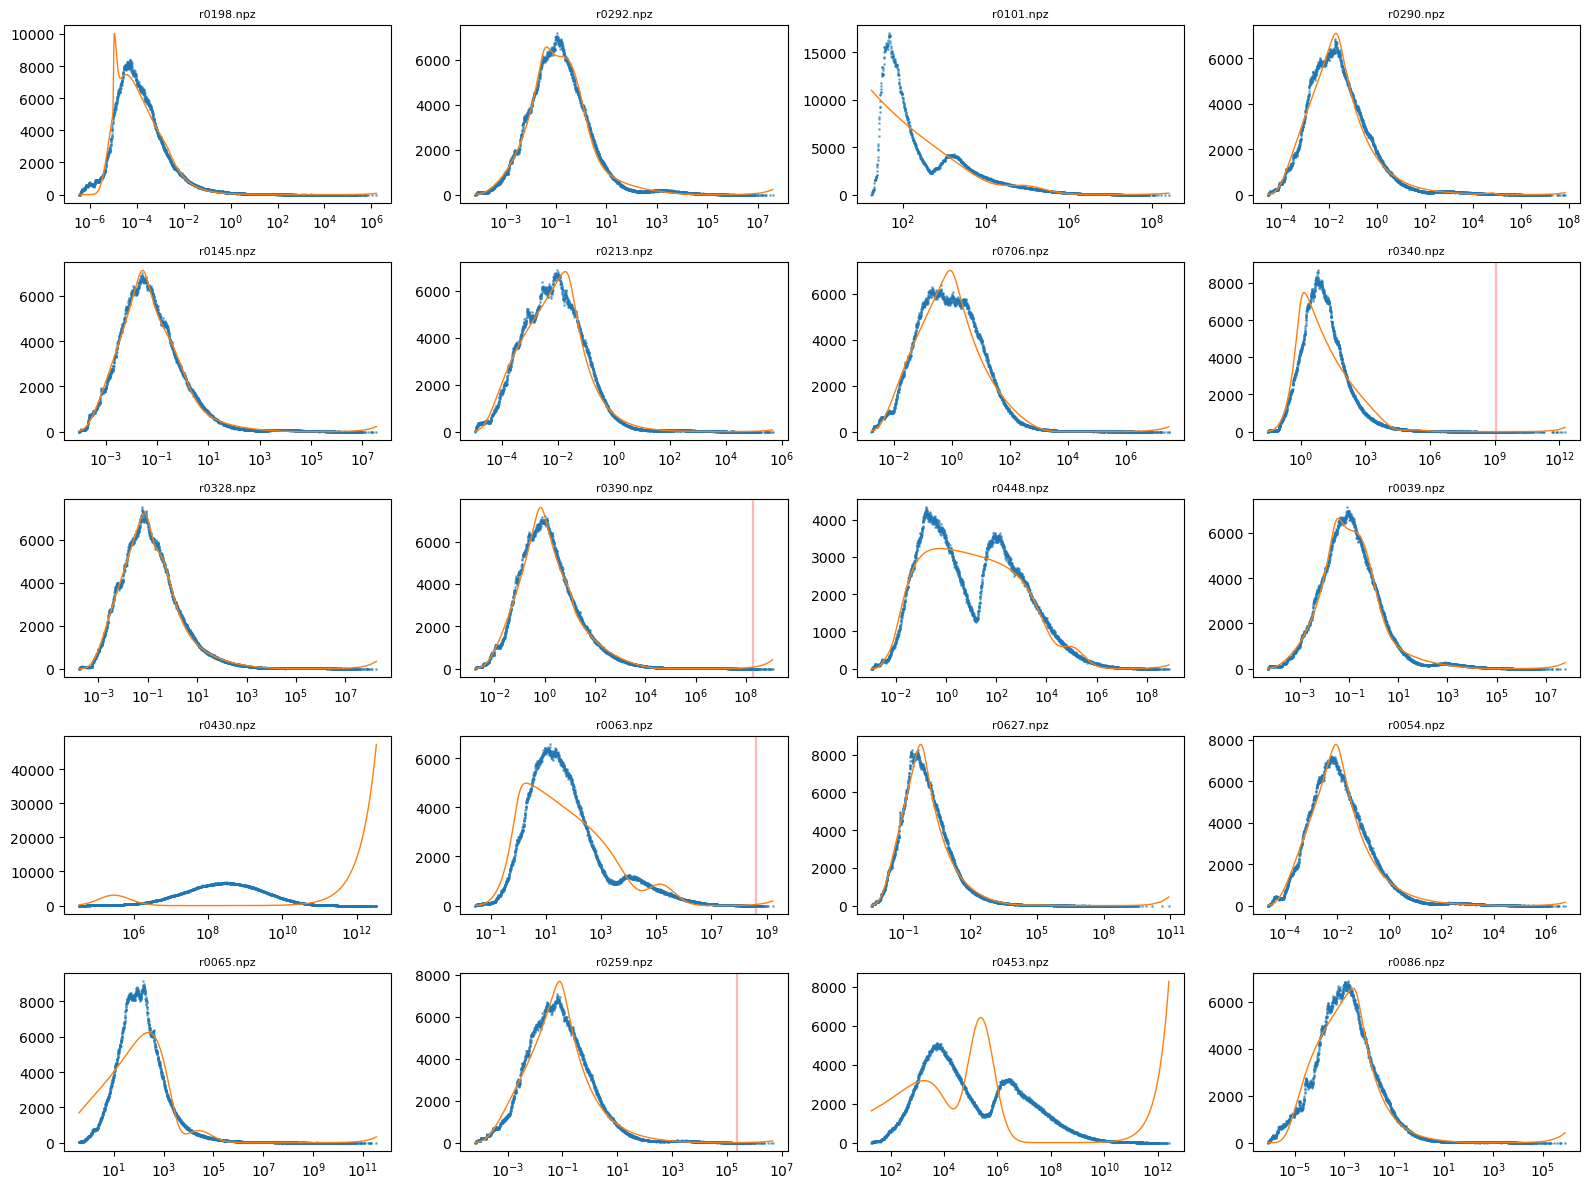

In [111]:
import numpy as np

# 假设所有 RID 的范围
all_rids = [f"r0{i:03d}" for i in range(0, 720)]  # 举例，按你数据的命名规则来
np.random.seed(42)  # 可选：设置随机种子以便复现
# 先随机挑 20 个 RID
chosen_rids = np.random.choice(all_rids, 20, replace=False)

# 再拼出文件路径
all_npz_files = [f"data_cache/hists/{rid}.npz" for rid in chosen_rids]

# 调用绘图函数
fit_and_plot_grid_parallel(all_npz_files)


In [112]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gammaln, erf, logsumexp
from scipy.signal import find_peaks, peak_widths, savgol_filter
from scipy.ndimage import median_filter

# ========================= 基础模型 =========================
def shape_sbpl2(mu, a_low, a_high, mub, q, mu0, muc, kt):
    mu = np.clip(mu, 1e-300, None)
    base = mu**(-a_low)
    br   = (1.0 + (mu/np.clip(mub,1e-30,None))**q) ** (-(a_high - a_low)/q)
    low  = np.exp(-mu0 / mu)
    high = np.exp(- (mu/np.clip(muc,1e-30,None))**np.clip(kt, 0.5, 8.0))
    return base * br * low * high

def shape_log_skew_normal(mu, m, s, skew):
    mu = np.clip(mu, 1e-300, None)
    s  = np.clip(s, 1e-9, None)
    z  = (np.log(mu) - m) / s
    phi = np.exp(-0.5*z*z) / np.sqrt(2*np.pi)
    Phi = 0.5 * (1.0 + erf(skew * z / np.sqrt(2.0)))
    return 2.0 * phi * Phi / (mu * s)

def shape_flat(mu):
    return np.ones_like(mu)

def to_density(shape_vals, dmu_local):
    Z = np.sum(shape_vals * dmu_local)
    return shape_vals / max(Z, 1e-300)

# ===================== 鲁棒尖峰检测与屏蔽 =====================
def _robust_sigma(x):
    med = np.median(x)
    mad = np.median(np.abs(x - med)) + 1e-12
    return 1.4826 * mad

def detect_and_mask_spike(mu, cnt, *,
                          win_frac=0.04,      # 背景窗口比例
                          z_thresh=6.0,       # 峰值z阈值
                          prom_ratio=4.0,     # prominence阈值
                          fwhm_frac=0.05,     # 屏蔽宽度 = FWHM * 5%
                          min_bins=2, max_bins=50,
                          ignore_mu_above=None):
    """
    返回 weights(同 cnt 形状；0=屏蔽) 和 (muL, muR) 区间或 None
    """
    n = len(mu)
    if n < 20:
        return np.ones_like(cnt, float), None

    if ignore_mu_above is not None:
        valid = mu <= ignore_mu_above
    else:
        valid = np.ones_like(mu, dtype=bool)

    w = max(9, int(np.round(win_frac * n)) | 1)   # 奇数窗口
    bg_med = median_filter(cnt, size=w, mode='nearest')
    bg = np.maximum(bg_med, 1.0)
    cnt_smooth = savgol_filter(cnt, window_length=min(w|1, 101), polyorder=2, mode='interp')

    z = (cnt - bg) / np.sqrt(bg + 1.0)
    sigma = _robust_sigma(z)
    if sigma <= 0: sigma = 1.0
    z /= sigma

    # 只在 valid 区间上找峰
    z_ = z.copy()
    z_[~valid] = -np.inf
    peaks, props = find_peaks(z_, prominence=z_thresh/2.0)
    if len(peaks) == 0:
        return np.ones_like(cnt, float), None

    good = []
    for j, i in enumerate(peaks):
        if z_[i] < z_thresh: 
            continue
        if props["prominences"][j] < prom_ratio:
            continue
        good.append(i)
    if not good:
        return np.ones_like(cnt, float), None

    i0 = int(good[np.argmax(z_[good])])

    widths, _, _, _ = peak_widths(cnt_smooth, [i0], rel_height=0.5)  # FWHM
    fwhm_bins = float(widths[0])

    width_bins = np.clip(fwhm_bins * fwhm_frac, min_bins, max_bins)
    halfw = int(max(1, np.round(width_bins / 2)))

    # 尾部上翘过滤：若右侧明显单调上升则认为是尾部，不屏蔽
    r = slice(i0, min(n, i0 + max(20, int(0.02*n))))
    if r.stop - r.start >= 10:
        if np.all(np.diff(cnt_smooth[r]) >= -1e-6) and (cnt_smooth[r.stop-1] > 1.5*cnt_smooth[r.start]):
            return np.ones_like(cnt, float), None

    idx = np.arange(n)
    mask = (np.abs(idx - i0) <= halfw)
    weights = np.ones_like(cnt, float)
    weights[mask] = 0.0
    muL = mu[max(0, i0 - halfw)]
    muR = mu[min(n - 1, i0 + halfw)]
    return weights, (muL, muR)

# ========================= 单文件拟合 =========================
def fit_one_npz(npz_file, dL=0.01, USE_BUMP1=True, USE_BUMP2=False, USE_FLAT=True,
                spike_cfg=None):
    d = np.load(npz_file)
    mu  = d["mu_log"].astype(float)
    cnt = d["cnt_log"].astype(float)

    mvalid = (mu > 0) & np.isfinite(cnt) & (cnt >= 0)
    mu  = mu[mvalid]
    cnt = cnt[mvalid]
    dmu = mu * (np.exp(dL) - 1.0)
    Ntot = cnt.sum()

    # ---- 鲁棒尖峰检测 ----
    spike_cfg = spike_cfg or {}
    weights, spike_range = detect_and_mask_spike(
        mu, cnt,
        win_frac=spike_cfg.get("win_frac", 0.04),
        z_thresh=spike_cfg.get("z_thresh", 6.0),
        prom_ratio=spike_cfg.get("prom_ratio", 4.0),
        fwhm_frac=spike_cfg.get("fwhm_frac", 0.05),
        min_bins=spike_cfg.get("min_bins", 2),
        max_bins=spike_cfg.get("max_bins", 50),
        ignore_mu_above=spike_cfg.get("ignore_mu_above", None),
    )

    # ---- 期望计数 ----
    def expected_counts(theta, mu_arr=mu, dmu_arr=dmu):
        idx = 0
        a_low, a_high, mub, mu0, muc, kt = theta[idx:idx+6]; idx += 6
        q = 5.0
        p_base = to_density(shape_sbpl2(mu_arr, a_low, a_high, mub, q, mu0, muc, kt), dmu_arr)
        comps = [p_base]
        if USE_BUMP1:
            m1, s1, sk1 = theta[idx:idx+3]; idx += 3
            s1 = np.clip(s1, 0.05, 1.2)
            p_b1 = to_density(shape_log_skew_normal(mu_arr, m1, s1, sk1), dmu_arr)
            comps.append(p_b1)
        if USE_BUMP2:
            m2, s2, sk2 = theta[idx:idx+3]; idx += 3
            s2 = np.clip(s2, 0.05, 1.2)
            p_b2 = to_density(shape_log_skew_normal(mu_arr, m2, s2, sk2), dmu_arr)
            comps.append(p_b2)
        ulist = [theta[idx]]; idx += 1
        if USE_BUMP1: ulist.append(theta[idx]); idx += 1
        if USE_BUMP2: ulist.append(theta[idx]); idx += 1
        if USE_FLAT:
            p_flat = to_density(shape_flat(mu_arr), dmu_arr)
            comps.append(p_flat)
            ulist.append(0.0)
        u = np.array(ulist, float)
        w = np.exp(u - logsumexp(u))
        pmix = np.zeros_like(mu_arr)
        for wi, pi in zip(w, comps):
            pmix += wi * pi
        logN = theta[idx]
        Nscale = np.exp(logN)
        lam = np.clip(Nscale * pmix * dmu_arr, 1e-30, None)
        return lam

    def nll(theta):
        lam = expected_counts(theta)
        return np.sum(weights * (lam - cnt*np.log(lam) + gammaln(cnt + 1.0)))

    # ---- 初值与边界 ----
    theta0 = [0.6, 2.2, 5e-3, 1e-3, 50.0, 2.5]
    bounds = [(0.1,3.0), (0.8,6.0), (1e-4,1.0), (1e-5,1e-1), (1e-1,1e4), (0.8,6.0)]
    if USE_BUMP1:
        theta0 += [-2.7, 0.35, 2.0]
        bounds += [(-12,12), (0.05,1.2), (-8.0,8.0)]
    if USE_BUMP2:
        theta0 += [np.log(5e2), 0.5, 0.0]
        bounds += [(np.log(1e2), np.log(1e4)), (0.05,1.2), (-8.0,8.0)]
    theta0 += [2.0] + ([0.0] if USE_BUMP1 else []) + ([0.0] if USE_BUMP2 else [])
    bounds += [(-8,8)] + ([(-8,8)] if USE_BUMP1 else []) + ([(-8,8)] if USE_BUMP2 else [])
    theta0 += [np.log(max(Ntot,1.0))]
    bounds += [(np.log(1e-2), np.log(1e12))]
    theta0 = np.array(theta0, float)

    # ---- 拟合 ----
    res = minimize(nll, theta0, bounds=bounds, method="L-BFGS-B")
    lam_fit = expected_counts(res.x)
    return mu, cnt, lam_fit, spike_range, npz_file

# ===================== 批量绘图（顺序执行） =====================
def fit_and_plot_grid(npz_files, k=20, seed=None, spike_cfg=None):
    """从 npz_files 随机选 k 个拟合并画 5×4（或自动行数）"""
    if seed is not None:
        np.random.seed(seed)
    k = min(k, len(npz_files))
    chosen_idx = np.random.choice(len(npz_files), k, replace=False)
    chosen = [npz_files[i] for i in chosen_idx]

    results = [fit_one_npz(f, spike_cfg=spike_cfg) for f in chosen]

    rows = (k + 3) // 4
    fig, axes = plt.subplots(rows, 4, figsize=(16, 3.2*rows))
    axes = axes.ravel()

    for ax, (mu, cnt, lam_fit, spike_range, fname) in zip(axes, results):
        ax.plot(mu, cnt, '.', ms=2, alpha=0.55, label='data')
        ax.plot(mu, lam_fit, '-', lw=1.2, label='fit')
        ax.set_xscale('log')
        if spike_range:
            ax.axvspan(spike_range[0], spike_range[1], color='tab:red', alpha=0.18)
        ax.set_title(fname.split('/')[-1], fontsize=9)
        ax.tick_params(labelsize=8)

    for ax in axes[len(results):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# ========================= 使用示例 =========================
# all_rids = [f"r0{i:03d}" for i in range(0, 720)]
# all_npz_files = [f"data_cache/hists/{rid}.npz" for rid in all_rids]
# fit_and_plot_grid(all_npz_files, k=20, seed=42,
#                   spike_cfg=dict(z_thresh=7.0, prom_ratio=5.0, ignore_mu_above=1e10))


/var/folders/6v/gtl342dj5dl_hv6tnw1f3_7w0000gn/T/ipykernel_52598/1368948614.py:89: PeakPropertyWarning: some peaks have a prominence of 0
  widths, _, _, _ = peak_widths(cnt_smooth, [i0], rel_height=0.5)  # FWHM
/var/folders/6v/gtl342dj5dl_hv6tnw1f3_7w0000gn/T/ipykernel_52598/1368948614.py:89: PeakPropertyWarning: some peaks have a width of 0
  widths, _, _, _ = peak_widths(cnt_smooth, [i0], rel_height=0.5)  # FWHM


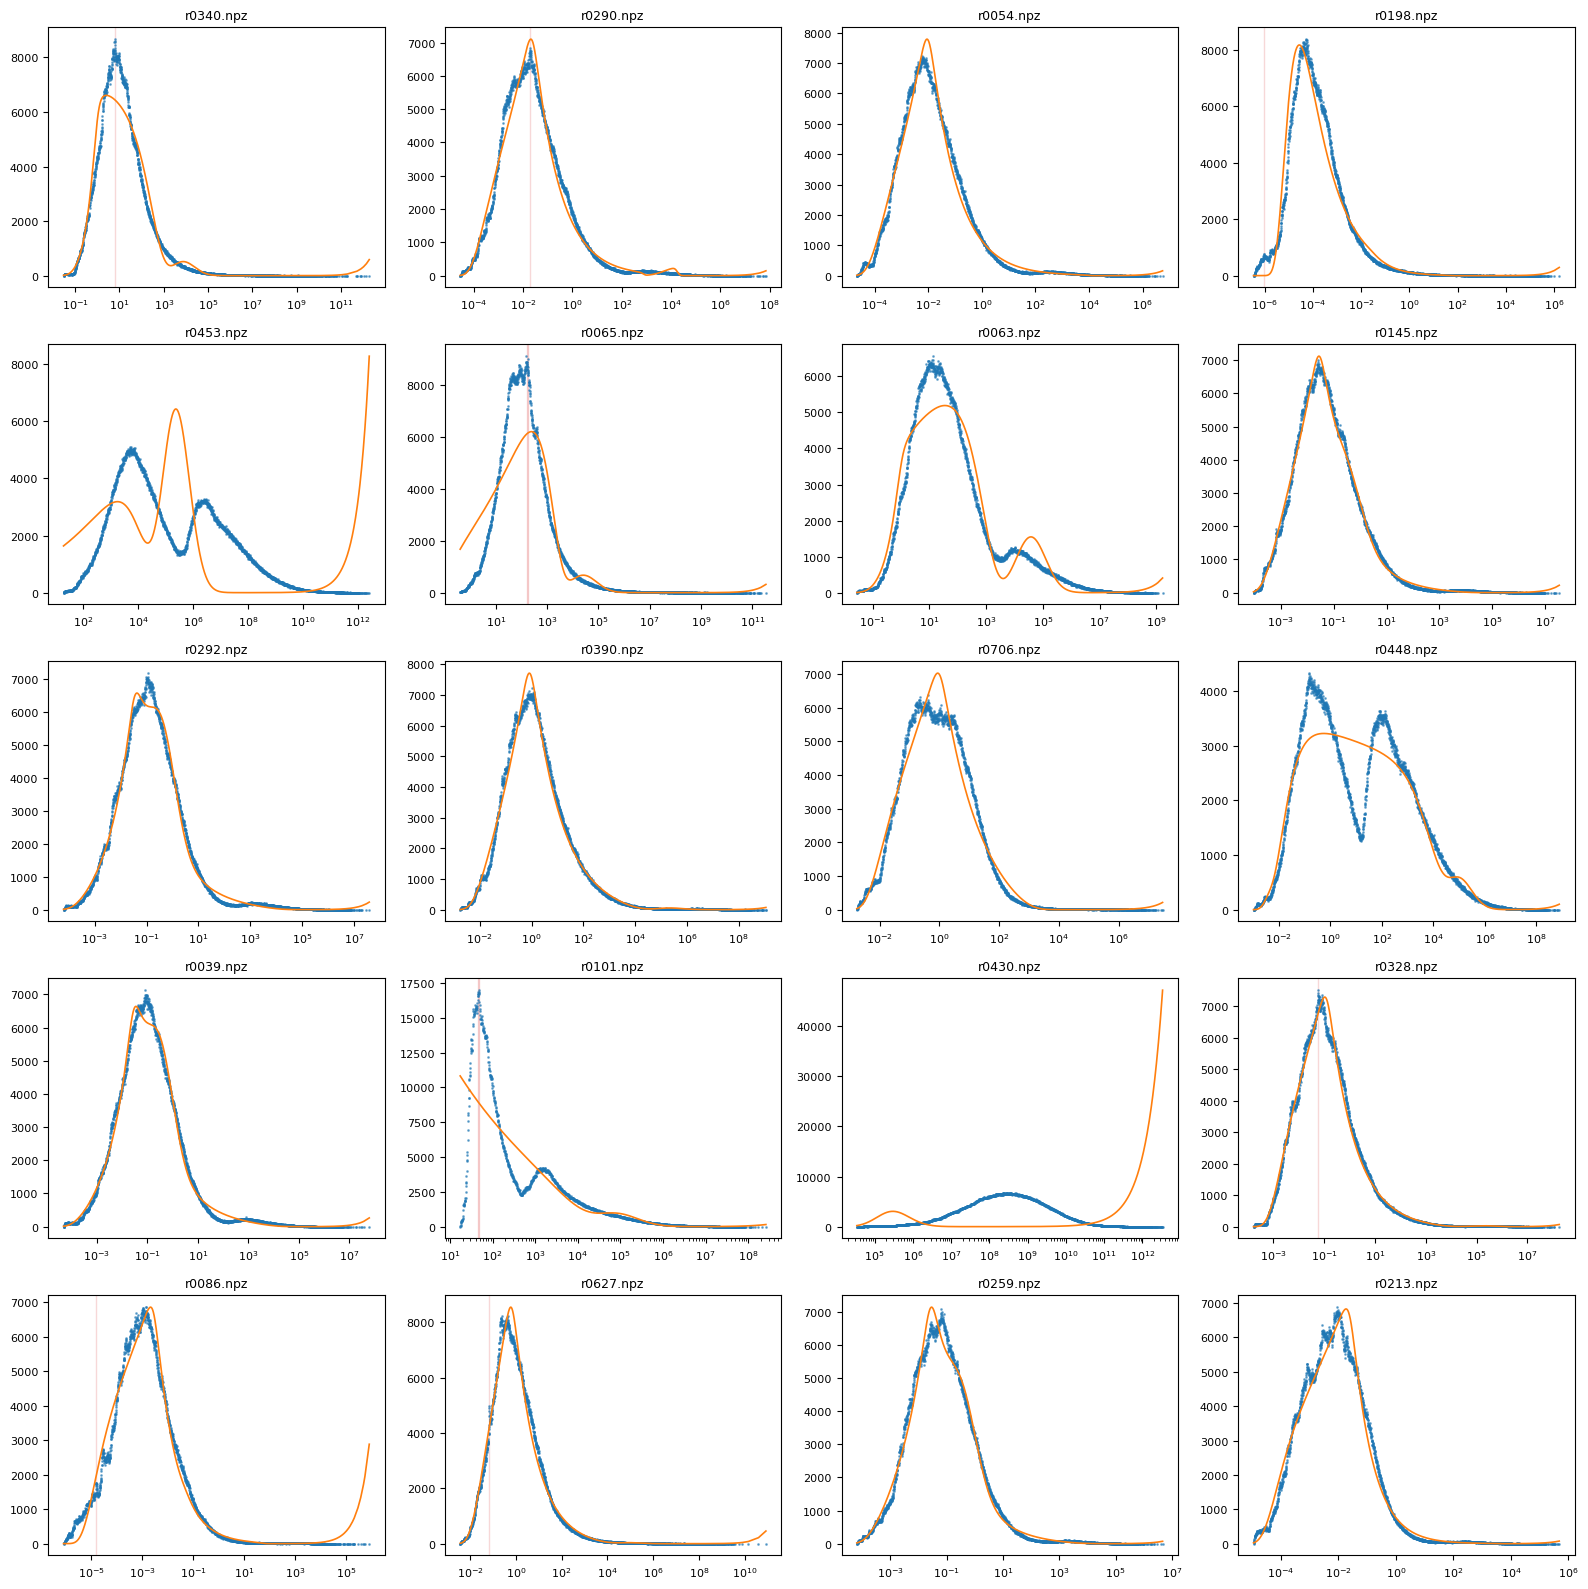

In [114]:
all_rids = [f"r0{i:03d}" for i in range(0, 720)]
all_npz_files = [f"data_cache/hists/{rid}.npz" for rid in all_rids]
fit_and_plot_grid(all_npz_files, k=20, seed=42,
                  spike_cfg=dict(z_thresh=7.0, prom_ratio=5.0, ignore_mu_above=1e10))


In [142]:
# microlens_pdf.py
import math, numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------
# 工具：数值安全与权重
# ---------------------------
def _softplus_min(x, min_val):
    # 确保>min_val的softplus
    return F.softplus(x) + min_val

def make_weights_from_hist(cnt, robust_spike=False, z_thresh=6.0, win=11):
    """
    可选：对极窄尖峰降权（不屏蔽，最多降到0.2）
    cnt: (B,) 直方图频数
    """
    w = np.ones_like(cnt, dtype=np.float32)
    if not robust_spike or len(cnt) < 20:
        return torch.from_numpy(w)
    from scipy.ndimage import median_filter
    bg = median_filter(cnt.astype(float), size=max(3, win|1), mode='nearest') + 1.0
    z = (cnt - bg) / np.sqrt(bg)
    med = np.median(z)
    mad = np.median(np.abs(z - med)) + 1e-12
    zscore = 1.4826*(z - med)/mad
    hi = np.where(zscore > z_thresh)[0]
    if len(hi):
        w[hi] = 0.2
    return torch.from_numpy(w)

# ---------------------------
# 条件 MDN + Pareto 尾 模型
# ---------------------------
class CondMDNPareto1D(nn.Module):
    """
    条件概率密度： p(mu|eta) = (1-w)*p_mix(mu|eta) + w*p_tail(mu|eta)
    其中 p_mix 来自对 log(mu) 的 K 分量高斯混合（再除以 mu 的Jacobian），
         p_tail 是 Pareto 尾：C * mu^{-alpha} * 1[mu>=mu_t]，C=(alpha-1)*mu_t^{alpha-1}
    所有参数 {pi_i, m_i, s_i, w, alpha, mu_t} 都由 MLP(eta) 输出
    """
    def __init__(self, K=6, hidden=(64,64), eta_norm=None,
                 min_sigma=0.03, min_alpha_plus=1e-3, mu_min=1e-9, mu_max=1e12):
        super().__init__()
        self.K = K
        self.min_sigma = float(min_sigma)
        self.min_alpha_plus = float(min_alpha_plus)
        self.mu_min = float(mu_min)
        self.mu_max = float(mu_max)

        # 归一化器（均值/方差），若不给则 identity
        if eta_norm is None:
            self.eta_mean = nn.Parameter(torch.zeros(3), requires_grad=False)
            self.eta_std  = nn.Parameter(torch.ones(3),  requires_grad=False)
        else:
            mean, std = eta_norm
            self.eta_mean = nn.Parameter(torch.tensor(mean, dtype=torch.float32), requires_grad=False)
            self.eta_std  = nn.Parameter(torch.tensor(std,  dtype=torch.float32), requires_grad=False)

        # MLP(eta) -> raw params
        in_dim = 3; out_dim = (3*K) + 1 + 1 + 1  # {m_i,s_i,logits_pi} + w_tail + alpha + mu_t
        layers = []
        last = in_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.SiLU()]
            last = h
        self.backbone = nn.Sequential(*layers)
        self.head = nn.Linear(last, out_dim)

    def _cond_params(self, eta):
        """
        eta: (...,3)  tensor  (kappa,gamma,s)
        returns dict of shaped tensors with batch dim
        """
        x = (eta - self.eta_mean) / (self.eta_std + 1e-8)
        h = self.backbone(x)
        raw = self.head(h)
        # split
        B = raw.shape[0]
        off = 0
        m = raw[:, off:off+self.K]; off += self.K
        s_raw = raw[:, off:off+self.K]; off += self.K
        logits_pi = raw[:, off:off+self.K]; off += self.K

        w_tail_logit = raw[:, off:off+1]; off += 1
        alpha_raw    = raw[:, off:off+1]; off += 1
        log_mu_t     = raw[:, off:off+1]; off += 1

        # transforms
        pi = F.softmax(logits_pi, dim=-1)                      # (B,K), sum=1
        sigma = _softplus_min(s_raw, self.min_sigma)           # >min_sigma
        w_tail = torch.sigmoid(w_tail_logit).clamp(1e-5, 1-1e-5)
        alpha = 1.0 + _softplus_min(alpha_raw, self.min_alpha_plus)  # >1
        mu_t  = torch.exp(log_mu_t).clamp(self.mu_min, self.mu_max*0.9)

        return {"m":m, "sigma":sigma, "pi":pi,
                "w":w_tail, "alpha":alpha, "mu_t":mu_t}

    def logpdf_logmu(self, y, eta):
        """
        y = log(mu): (...,N) 或 (N,)
        返回 log p_log(y|eta)
        """
        y = torch.as_tensor(y, dtype=torch.float32, device=next(self.parameters()).device)
        eta = torch.as_tensor(eta, dtype=torch.float32, device=y.device)
        if y.dim()==1:  y = y.unsqueeze(0)   # (1,N)
        if eta.dim()==1: eta = eta.unsqueeze(0)  # (1,3)
        B, N = eta.shape[0], y.shape[-1]

        pars = self._cond_params(eta)
        m, sigma, pi = pars["m"][:,None,:], pars["sigma"][:,None,:], pars["pi"][:,None,:]  # (B,1,K)

        # mix on y
        y_ = y[...,None]  # (B,N,1)
        logN = -0.5*((y_-m)/sigma)**2 - torch.log(sigma) - 0.5*math.log(2*math.pi)  # (B,N,K)
        log_mix = torch.logsumexp(torch.log(pi) + logN, dim=-1)                     # (B,N)

        # tail on y: exponential with rate (alpha-1), shifted at y_t
        w, alpha, mu_t = pars["w"], pars["alpha"], pars["mu_t"]  # (B,1)
        y_t = torch.log(mu_t)
        rate = (alpha - 1.0).clamp_min(1e-6)                     # (B,1)
        log_tail = torch.log(rate) - rate*(y - y_t)              # (B,N)
        mask = (y >= y_t)
        log_tail = torch.where(mask, log_tail, torch.full_like(log_tail, -1e30))

        # mix two parts in log-space
        logp_log = torch.logsumexp(torch.stack([
            torch.log(1.0 - w) + log_mix,
            torch.log(w)       + log_tail
        ], dim=0), dim=0)  # (B,N)
        return logp_log

    # 如需 μ 空间 pdf/logpdf 可派生：
    def logpdf(self, mu, eta):
        mu = torch.as_tensor(mu, dtype=torch.float32, device=next(self.parameters()).device)
        y = torch.log(mu.clamp(self.mu_min, self.mu_max))
        return self.logpdf_logmu(y, eta) - torch.log(mu.clamp_min(self.mu_min))

    def pdf_logmu(self, y, eta):
        return torch.exp(self.logpdf_logmu(y, eta))

    def pdf(self, mu, eta):
        return torch.exp(self.logpdf(mu, eta))

    # def pdf(self, mu, eta):
    #     return torch.exp(self.logpdf(mu, eta))
    @torch.no_grad()
    def sample(self, eta, n=1000):
        device = next(self.parameters()).device
        eta = torch.as_tensor(eta, dtype=torch.float32, device=device).view(1,3)
        pars = self._cond_params(eta)
        w, alpha, mu_t = pars["w"].item(), pars["alpha"].item(), pars["mu_t"].item()
        m  = pars["m"].view(-1).cpu().numpy()
        sg = pars["sigma"].view(-1).cpu().numpy()
        pi = pars["pi"].view(-1).cpu().numpy()

        n_tail = np.random.binomial(n, w)
        n_mix  = n - n_tail
        out = np.empty(n, dtype=np.float64)

        # tail in y: y = y_t + Exp(rate), rate = alpha-1
        if n_tail>0:
            rate = max(alpha-1.0, 1e-6)
            y_t  = math.log(mu_t)
            E = np.random.exponential(scale=1.0/rate, size=n_tail)
            out[:n_tail] = np.exp(y_t + E)

        # mix in y: y ~ N(m_i, sigma_i), mu = exp(y)
        if n_mix>0:
            idx = np.random.choice(len(pi), size=n_mix, p=pi/np.sum(pi))
            y = np.random.normal(loc=m[idx], scale=sg[idx])
            out[n_tail:] = np.exp(y)
        return out


# ---------------------------
# 训练：基于直方图的交叉熵（等价无尺度 Poisson NLL）
# ---------------------------
class HistTrainer:
    """
    用多组 (eta, hist) 训练模型
    hist 为 logμ 等距直方图：键需包含 'eta','y','dL','cnt'
    """
    def __init__(self, model: CondMDNPareto1D, lr=1e-3, wd=0.0, device=None):
        self.model = model
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.opt = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=wd)

    def step_on_example(self, example, robust_spike=False):
        """
        example keys:
          'eta' : (3,) array  (kappa,gamma,s)
          'y'   : (N,) log(mu) bin centers
          'dL'  : float, log-bin 步长
          'cnt' : (N,) counts
        """
        eta = np.asarray(example['eta'], float)
        y   = np.asarray(example['y'],   float)
        dL  = float(example['dL'])
        cnt = np.asarray(example['cnt'], float)

        # 归一化直方图 → 概率质量
        cnt = np.clip(cnt, 0.0, None)
        mass_data = cnt / max(cnt.sum(), 1.0)

        # 可选：对异常窄尖峰降权（不需要可设 False）
        w = make_weights_from_hist(cnt, robust_spike=robust_spike).numpy().astype(np.float32)

        # to tensors
        eta = torch.tensor(eta, dtype=torch.float32, device=self.device).unsqueeze(0)  # (1,3)
        y   = torch.tensor(y,   dtype=torch.float32, device=self.device).unsqueeze(0)  # (1,N)
        mass_data = torch.tensor(mass_data, dtype=torch.float32, device=self.device).unsqueeze(0)  # (1,N)
        w = torch.tensor(w, dtype=torch.float32, device=self.device).unsqueeze(0)  # (1,N)

        # 前向：预测 p_log(y)
        self.opt.zero_grad()
        logp_log = self.model.logpdf_logmu(y, eta)        # (1,N)
        mass_pred = torch.exp(logp_log) * dL              # 预测的 bin 概率质量
        mass_pred = mass_pred / (mass_pred.sum(dim=1, keepdim=True) + 1e-12)

        # 交叉熵（带权）
        loss = -(w * mass_data * torch.log(mass_pred.clamp_min(1e-30))).sum()
        loss.backward()
        self.opt.step()
        return float(loss.item())

    def fit(self, dataset, epochs=500, robust_spike=False, log_every=50):
        for ep in range(1, epochs+1):
            total = 0.0
            for ex in dataset:
                total += self.step_on_example(ex, robust_spike=robust_spike)
            if (ep % log_every) == 0:
                print(f"[ep {ep}] loss={total/len(dataset):.6f}")


# ---------------------------
# 可选：从 log-bin 数据构造 mu/dmu
# ---------------------------
def from_log_hist(mu_log_centers, cnt, dL):
    y   = np.asarray(mu_log_centers, float)  # 就是 log(mu)
    cnt = np.asarray(cnt, float)
    return y, cnt, float(dL)



In [143]:
import pandas as pd
df = pd.read_csv("samples_mixed.csv")
df

,kappa,gamma,s
0,0.557058,0.925922,0.565913
1,0.754571,0.804400,0.233205
2,1.455401,0.725475,0.609941
3,2.642675,1.738077,0.335720
4,1.753366,1.267367,0.199408
...,...,...,...
2995,2.264038,1.612456,0.176798
2996,0.852282,2.344563,0.182350
2997,3.044537,3.067753,0.088515
2998,0.996861,0.596077,0.316803


In [ ]:
import numpy as np

import pandas as pd
df = pd.read_csv("samples_mixed.csv")

np.random.seed(42)
all_rids = range(0, 720)
chosen_rids = np.random.choice(all_rids, 20, replace=False)
dataset = []
EPS = 1e-12
for rid in chosen_rids:
    ridname = f"r0{rid:03d}"
    d = np.load(f"data_cache/hists/{ridname}.npz")

    y   = np.asarray(d["mu_log"], dtype=float)   # log μ bin centers
    cnt = np.asarray(d["cnt_log"], dtype=float)  # counts
    dL  = 0.01                                   # log-bin 宽度

    cnt = np.clip(cnt, 0.0, None)
    if cnt.sum() <= 0:
        continue

    kappa, gamma, s = df.iloc[rid]

    dataset.append(dict(
        eta=np.array([float(kappa), float(gamma), float(s)], dtype=float),
        y=y.astype(float),           # log μ bin centers
        dL=float(dL),                # bin 宽度
        cnt=cnt.astype(float),       # bin 频数
    ))



In [200]:
etas = np.stack([ex['eta'] for ex in dataset], axis=0)
eta_mean, eta_std = etas.mean(0), etas.std(0) + 1e-6

model = CondMDNPareto1D(K=6, hidden=(64,64), eta_norm=(eta_mean, eta_std))
trainer = HistTrainer(model, lr=1e-5)
trainer.fit(dataset, epochs=800, robust_spike=False, log_every=50)


[ep 50] loss=18.275317
[ep 100] loss=16.724614
[ep 150] loss=15.250851
[ep 200] loss=13.950766


KeyboardInterrupt: 

/var/folders/6v/gtl342dj5dl_hv6tnw1f3_7w0000gn/T/ipykernel_52598/2577429938.py:15: RuntimeWarning: overflow encountered in exp
  pdf_mu_pred = pdf_logmu_pred / np.exp(y.cpu().numpy()[0])      # 转成 mu 空间 pdf
/var/folders/6v/gtl342dj5dl_hv6tnw1f3_7w0000gn/T/ipykernel_52598/2577429938.py:23: RuntimeWarning: overflow encountered in exp
  plt.plot(np.exp(ex['y']), mass_data/dL, 'o-', label='Data (hist / dL)')
/var/folders/6v/gtl342dj5dl_hv6tnw1f3_7w0000gn/T/ipykernel_52598/2577429938.py:24: RuntimeWarning: overflow encountered in exp
  plt.plot(np.exp(ex['y']), pdf_mu_pred, 'r-', label='Model PDF')


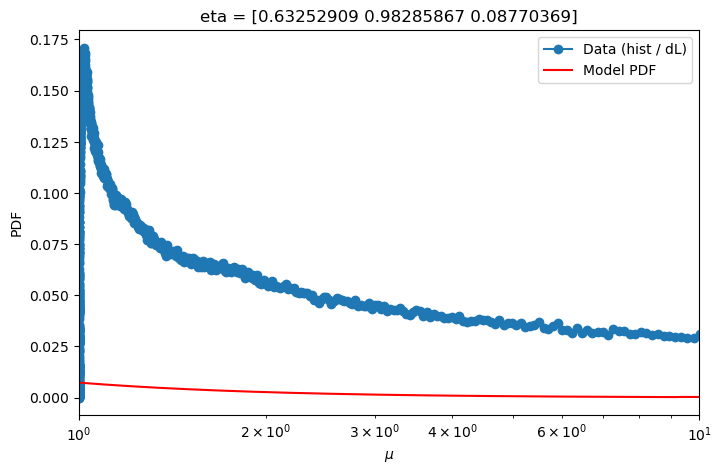

In [178]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 随机挑一个训练样本
ex = dataset[1]

eta = torch.tensor(ex['eta'], dtype=torch.float32).unsqueeze(0)
y   = torch.tensor(ex['y'], dtype=torch.float32).unsqueeze(0)  # log(mu)
dL  = ex['dL']

# 模型预测 log(mu) 空间的 pdf
with torch.no_grad():
    pdf_logmu_pred = model.pdf_logmu(y, eta).cpu().numpy()[0]  # shape (N,)
pdf_mu_pred = pdf_logmu_pred / np.exp(y.cpu().numpy()[0])      # 转成 mu 空间 pdf

# 原始数据归一化成概率质量
cnt = ex['cnt']
mass_data = cnt / cnt.sum()

# 画图
plt.figure(figsize=(8,5))
plt.plot(np.exp(ex['y']), mass_data/dL, 'o-', label='Data (hist / dL)')
plt.plot(np.exp(ex['y']), pdf_mu_pred, 'r-', label='Model PDF')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$\mu$')
plt.ylabel('PDF')
plt.legend()
plt.title(f"eta = {ex['eta']}")
plt.show()


In [201]:
import math
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# =============================================================
# 数据接口说明
# dataset: List[dict]，每个元素包含：
#   'eta': np.ndarray shape (3,)  -> (kappa, gamma, s)
#   'y'  : np.ndarray shape (N,)  -> log(mu) 等距网格中心
#   'dL' : float                  -> log-bin 宽度
#   'cnt': np.ndarray shape (N,)  -> 每个 bin 的原始计数 (不归一)
#
# 训练目标：在 y 上拟合条件密度 p_logmu(y | eta)。
# 损失函数：Poisson NLL on counts。
# 评估指标：离散 KL(q||p)，右尾幂律斜率估计。
# =============================================================

# ---------------------------
# 工具：稳定函数与度量
# ---------------------------

def _logsumexp(a: torch.Tensor, dim: int = -1, keepdim: bool = False) -> torch.Tensor:
    m, _ = torch.max(a, dim=dim, keepdim=True)
    z = m + torch.log(torch.clamp((a - m).exp().sum(dim=dim, keepdim=True), min=1e-30))
    return z if keepdim else z.squeeze(dim)


def kl_discrete(q: np.ndarray, p: np.ndarray, eps: float = 1e-12) -> float:
    """KL(q||p) on discrete bins; q, p are probabilities over same support."""
    q = np.clip(q, eps, 1.0)
    p = np.clip(p, eps, 1.0)
    q /= q.sum()
    p /= p.sum()
    return float(np.sum(q * (np.log(q) - np.log(p))))


def tail_slope_loglog(y: np.ndarray, pdf: np.ndarray, mass_fraction: float = 0.1) -> float:
    """在右尾按质量分数选区间，做 log(mu)-log(pdf(mu)) 的线性回归估计斜率。
    返回 μ 域幂律指数 alpha，使 p(μ) ~ μ^{-alpha}；若无法估计则返回 nan。
    注意：输入是 logμ 网格 y 与对应 pdf_logmu(y) 在 μ 域的 pdf(y)/exp(y) 已转换后的 pdf_mu。
    """
    eps = 1e-300
    mu = np.exp(y)
    pdf_mu = np.clip(pdf, eps, None)
    mass = pdf_mu / pdf_mu.sum()
    # 找到右端使累计质量 >= mass_fraction
    cumsum = np.cumsum(mass)
    idx0 = np.searchsorted(cumsum, 1.0 - mass_fraction)
    if idx0 >= len(y) - 5:
        return float('nan')
    xs = np.log(mu[idx0:])
    ys = np.log(pdf_mu[idx0:])
    # 线性拟合: ys = a + b * xs，幂律指数 alpha = -b
    A = np.vstack([np.ones_like(xs), xs]).T
    try:
        coef, *_ = np.linalg.lstsq(A, ys, rcond=None)
        b = coef[1]
        alpha = -b
        return float(alpha)
    except Exception:
        return float('nan')


# ---------------------------
# 数据集包装
# ---------------------------

class HistListDataset(Dataset):
    def __init__(self, items: List[Dict], eta_mean=None, eta_std=None, y_shared: Optional[np.ndarray] = None):
        assert len(items) > 0
        self.items = items
        # 归一化 (eta)
        etas = np.stack([it['eta'] for it in items], axis=0).astype(np.float32)
        self.eta_mean = etas.mean(0) if eta_mean is None else np.asarray(eta_mean, np.float32)
        self.eta_std  = etas.std(0) + 1e-6 if eta_std is None else np.asarray(eta_std, np.float32)
        # 统一 y 网格检查
        if y_shared is None:
            ys = [tuple(np.round(it['y'].astype(float), 12)) for it in items]
            # 简单检查：要求所有 y 完全一致
            if not all(ys[0] == y for y in ys):
                raise ValueError("All examples must share the same y grid. Provide y_shared if you want to force.")
            self.y = items[0]['y'].astype(np.float32)
        else:
            self.y = y_shared.astype(np.float32)
        self.dL = float(items[0]['dL'])

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        it = self.items[idx]
        eta = (it['eta'].astype(np.float32) - self.eta_mean) / self.eta_std
        y   = self.y  # shared
        cnt = it['cnt'].astype(np.float32)
        N   = float(cnt.sum())
        return {
            'eta': torch.from_numpy(eta),
            'y':   torch.from_numpy(y),
            'cnt': torch.from_numpy(cnt),
            'N':   torch.tensor(N, dtype=torch.float32),
            'rid': it.get('rid', idx),
        }


# ---------------------------
# 模型：条件 MDN on y=logmu
# ---------------------------

class MDNLogMu(nn.Module):
    def __init__(self,
                 in_dim: int = 3,
                 hidden: Tuple[int, int] = (128, 128),
                 K: int = 8,
                 sigma_min: float = 0.06,
                 softmax_temperature: float = 1.8):
        super().__init__()
        self.K = K
        self.sigma_min = float(sigma_min)
        self.T = float(softmax_temperature)

        layers = []
        last = in_dim
        for h in hidden:
            layers += [nn.Linear(last, h), nn.SiLU()]
            last = h
        self.net = nn.Sequential(*layers)
        self.head = nn.Linear(last, 3 * K)  # m, s_raw, logits

    def forward(self, eta: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """返回 log p_logmu(y | eta) with shape (B, N)."""
        B, N = eta.shape[0], y.shape[-1]
        h = self.net(eta)
        raw = self.head(h)
        m, s_raw, logits = torch.chunk(raw, 3, dim=-1)  # (B,K)
        sigma = F.softplus(s_raw) + self.sigma_min
        logits = logits / self.T
        log_pi = logits - _logsumexp(logits, dim=-1, keepdim=True)  # log softmax

        y_ = y.unsqueeze(-1)  # (B,N,1)
        m = m.unsqueeze(1)    # (B,1,K)
        sigma = sigma.unsqueeze(1)
        log_pi = log_pi.unsqueeze(1)

        logN = -0.5 * ((y_ - m) / sigma) ** 2 - torch.log(sigma) - 0.5 * math.log(2 * math.pi)
        log_mix = _logsumexp(log_pi + logN, dim=-1)  # (B,N)
        return log_mix

    @torch.no_grad()
    def pdf_logmu(self, eta: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        return torch.exp(self.forward(eta, y))


# ---------------------------
# 训练器（Poisson NLL + 早停 + 验证指标）
# ---------------------------

@dataclass
class TrainConfig:
    lr: float = 1e-5
    epochs: int = 300
    batch_size: int = 16
    weight_decay: float = 0.0
    warmup_epochs: int = 5
    min_lr: float = 1e-7
    patience: int = 20
    tail_reg_lambda: float = 0.05  # 乘以 s 的强度见下方注释
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'


class Trainer:
    def __init__(self, model: MDNLogMu, cfg: TrainConfig, y: np.ndarray, dL: float,
                 eta_denorm: Tuple[np.ndarray, np.ndarray]):
        self.model = model.to(cfg.device)
        self.cfg = cfg
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=cfg.epochs, eta_min=cfg.min_lr)
        self.y = torch.tensor(y.astype(np.float32), device=cfg.device).unsqueeze(0)  # (1,N)
        self.dL = float(dL)
        self.eta_mean, self.eta_std = eta_denorm

    def poisson_nll(self, logp_log: torch.Tensor, cnt: torch.Tensor, N: torch.Tensor) -> torch.Tensor:
        # p_i ≈ p_log(y_i) * dL
        mass = torch.exp(logp_log) * self.dL  # (B,N)
        mass = mass / (mass.sum(dim=1, keepdim=True) + 1e-30)
        lam = torch.clamp(N.unsqueeze(-1) * mass, min=1e-30)
        # sum_i (lam_i - c_i log lam_i)
        return (lam - cnt * torch.log(lam)).sum(dim=1).mean()

    def estimate_tail_alpha_batch(self, pdf_log: torch.Tensor) -> torch.Tensor:
        """基于当前 batch 的 pdf_logmu -> 转成 pdf_mu 后估计右尾幂律指数; 返回 (B,) 张量，可能含 nan。"""
        with torch.no_grad():
            y = self.y  # (1,N)
            pdf_logmu = torch.exp(pdf_log)  # (B,N)
            pdf_mu = pdf_logmu / torch.exp(y)  # Jacobian: p_mu = p_log / mu
            pdf_mu = pdf_mu / (pdf_mu.sum(dim=1, keepdim=True) + 1e-30)
            B = pdf_mu.shape[0]
            res = []
            for b in range(B):
                alpha = tail_slope_loglog(y.cpu().numpy().squeeze(), pdf_mu[b].cpu().numpy(), mass_fraction=0.1)
                res.append(alpha)
            return torch.tensor(res, dtype=torch.float32, device=pdf_log.device)

    def train_epoch(self, loader: DataLoader) -> float:
        self.model.train()
        total = 0.0
        for batch in loader:
            eta = batch['eta'].to(self.cfg.device)
            cnt = batch['cnt'].to(self.cfg.device)
            N   = batch['N'].to(self.cfg.device)
            # 前向
            logp_log = self.model(eta, self.y.expand(eta.size(0), -1))
            loss_p = self.poisson_nll(logp_log, cnt, N)
            # 尾部软正则（随 s 加权）：估计 alpha，并拉近到 3
            # 反归一 s： s = eta_std[2]*eta_norm + eta_mean[2]
            with torch.no_grad():
                s_raw = eta[:, 2] * self.eta_std[2] + self.eta_mean[2]
                s_w = torch.clamp(s_raw, min=0.0)
            alpha_hat = self.estimate_tail_alpha_batch(logp_log)
            mask = torch.isfinite(alpha_hat)
            if mask.any():
                tail_reg = ((alpha_hat[mask] - 3.0) ** 2 * s_w[mask]).mean() * self.cfg.tail_reg_lambda
            else:
                tail_reg = torch.tensor(0.0, device=self.cfg.device)

            loss = loss_p + tail_reg

            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)
            self.optimizer.step()

            total += float(loss.item())
        self.scheduler.step()
        return total / max(1, len(loader))

    @torch.no_grad()
    def evaluate(self, loader: DataLoader) -> Tuple[float, float, float]:
        self.model.eval()
        y = self.y
        dL = self.dL
        kl_list = []
        tail_list = []
        nll_list = []
        for batch in loader:
            eta = batch['eta'].to(self.cfg.device)
            cnt = batch['cnt'].to(self.cfg.device)
            N   = batch['N'].to(self.cfg.device)

            logp_log = self.model(eta, y.expand(eta.size(0), -1))
            # NLL
            nll = self.poisson_nll(logp_log, cnt, N).item()
            nll_list.append(nll)
            # KL
            pdf_logmu = torch.exp(logp_log)
            mass_model = (pdf_logmu * dL)
            mass_model = (mass_model / (mass_model.sum(dim=1, keepdim=True) + 1e-30)).cpu().numpy()
            cnt_np = cnt.cpu().numpy()
            for b in range(cnt_np.shape[0]):
                q = cnt_np[b] / max(1.0, cnt_np[b].sum())
                p = mass_model[b]
                kl_list.append(kl_discrete(q, p))
            # tail
            tail_alpha = self.estimate_tail_alpha_batch(logp_log)
            for a in tail_alpha.tolist():
                tail_list.append(a)
        kl_med = float(np.nanmedian(kl_list)) if len(kl_list) else float('nan')
        tail_med = float(np.nanmedian(tail_list)) if len(tail_list) else float('nan')
        nll_mean = float(np.mean(nll_list)) if len(nll_list) else float('nan')
        return nll_mean, kl_med, tail_med

    def fit(self, train_ds: Dataset, val_ds: Dataset) -> Dict:
        train_loader = DataLoader(train_ds, batch_size=self.cfg.batch_size, shuffle=True, drop_last=False)
        val_loader   = DataLoader(val_ds, batch_size=self.cfg.batch_size, shuffle=False, drop_last=False)

        best = {
            'epoch': -1,
            'state': None,
            'val_nll': float('inf'),
            'val_kl': float('inf'),
            'val_tail_med': float('nan'),
        }
        no_improve = 0

        for ep in range(1, self.cfg.epochs + 1):
            tr_loss = self.train_epoch(train_loader)
            val_nll, val_kl, val_tail = self.evaluate(val_loader)
            improved = val_nll < best['val_nll'] - 1e-6
            if improved:
                best.update(epoch=ep, state=self.model.state_dict(), val_nll=val_nll, val_kl=val_kl, val_tail_med=val_tail)
                no_improve = 0
            else:
                no_improve += 1

            print(f"[ep {ep:03d}] train_loss={tr_loss:.4f} | val_NLL={val_nll:.4f} | val_KLmed={val_kl:.4f} | val_tail_med≈{val_tail:.2f} | lr={self.scheduler.get_last_lr()[0]:.2e}")

            if no_improve >= self.cfg.patience:
                print(f"Early stop at epoch {ep} (patience={self.cfg.patience}). Best val_NLL={best['val_nll']:.4f} at ep={best['epoch']}.")
                break

        if best['state'] is not None:
            self.model.load_state_dict(best['state'])
        return best


# ---------------------------
# 快速上手入口（示例）：
# 传入: dataset(list of dict)，按 rid 划分 train/val，开始训练并保存模型
# ---------------------------

def split_train_val(items: List[Dict], val_ratio: float = 0.2, seed: int = 0):
    rng = random.Random(seed)
    idx = list(range(len(items)))
    rng.shuffle(idx)
    n_val = max(1, int(len(items) * val_ratio))
    val_idx = set(idx[:n_val])
    train_items = [items[i] for i in range(len(items)) if i not in val_idx]
    val_items   = [items[i] for i in range(len(items)) if i in val_idx]
    return train_items, val_items


def run_training(dataset: List[Dict], out_ckpt: str = 'mdn_logmu_ckpt.pt'):
    assert len(dataset) > 0
    # 统一 y 与 dL 检查
    y = dataset[0]['y']
    dL = float(dataset[0]['dL'])
    if not all(np.allclose(y, it['y']) for it in dataset):
        raise ValueError('All examples must share identical y grid.')

    # 划分训练/验证
    train_items, val_items = split_train_val(dataset, val_ratio=0.2, seed=0)

    # 归一化统计
    etas = np.stack([it['eta'] for it in dataset], axis=0).astype(np.float32)
    eta_mean, eta_std = etas.mean(0), etas.std(0) + 1e-6

    # 数据集对象
    train_ds = HistListDataset(train_items, eta_mean=eta_mean, eta_std=eta_std, y_shared=y)
    val_ds   = HistListDataset(val_items,   eta_mean=eta_mean, eta_std=eta_std, y_shared=y)

    # 模型 & 训练器
    model = MDNLogMu(in_dim=3, hidden=(128, 128), K=8, sigma_min=0.06, softmax_temperature=1.8)
    cfg = TrainConfig()
    trainer = Trainer(model, cfg, y=y, dL=dL, eta_denorm=(eta_mean, eta_std))

    best = trainer.fit(train_ds, val_ds)

    # 保存
    torch.save({
        'model_state': model.state_dict(),
        'eta_mean': eta_mean,
        'eta_std': eta_std,
        'y': y,
        'dL': dL,
        'best_meta': best,
        'cfg': cfg.__dict__,
    }, out_ckpt)
    print(f"Saved checkpoint to: {out_ckpt}")

    return model, (eta_mean, eta_std), y, dL, best


# ---------------------------
# 推断接口（给定 (kappa,gamma,s) 得到 pdf(y) 与 pdf(mu)）
# ---------------------------

@torch.no_grad()
def evaluate_pdf(model: MDNLogMu, eta_raw: np.ndarray, eta_mean: np.ndarray, eta_std: np.ndarray,
                 y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    device = next(model.parameters()).device
    eta = (eta_raw.astype(np.float32) - eta_mean) / eta_std
    eta_t = torch.from_numpy(eta).unsqueeze(0).to(device)
    y_t = torch.from_numpy(y.astype(np.float32)).unsqueeze(0).to(device)
    pdf_log = model.pdf_logmu(eta_t, y_t).cpu().numpy()[0]
    pdf_mu  = pdf_log / np.exp(y)
    # 归一化（数值安全）
    pdf_log /= (np.trapz(pdf_log, x=y) + 1e-30)
    pdf_mu  /= (np.trapz(pdf_mu,  x=np.exp(y)) + 1e-30)
    return pdf_log, pdf_mu


# ==========================
# 使用示例（取消注释后运行）
# ==========================
# if __name__ == '__main__':
#     # 这里假设你已有 dataset(list of dict)，键包含 'eta','y','dL','cnt'（见文件开头）。
#     # 例如：
#     # from your_data_loader import dataset
#     # model, (eta_mean, eta_std), y, dL, best = run_training(dataset, out_ckpt='mdn_logmu_ckpt.pt')
#     #
#     # # 评估某个条件
#     # eta_test = np.array([0.45, 0.25, 0.5], dtype=np.float32)
#     # pdf_log, pdf_mu = evaluate_pdf(model, eta_test, eta_mean, eta_std, y)
#     # print('pdf_log sum≈', np.trapz(pdf_log, x=y))
#     # print('pdf_mu  sum≈', np.trapz(pdf_mu,  x=np.exp(y)))
#     pass


In [202]:
import numpy as np
from scipy.interpolate import interp1d

np.random.seed(42)
all_rids = range(0, 720)
chosen_rids = np.random.choice(all_rids, 20, replace=False)

# Step 1: 找全局范围
y_min = float("inf")
y_max = -float("inf")
for rid in chosen_rids:
    d = np.load(f"data_cache/hists/r0{rid:03d}.npz")
    y_min = min(y_min, d["logmu_mid"].min())
    y_max = max(y_max, d["logmu_mid"].max())

# Step 2: 生成统一网格
dL = 0.01
y_shared = np.arange(y_min, y_max + dL/2, dL)

# Step 3: 插值并构造 dataset
dataset = []
for rid in chosen_rids:
    d = np.load(f"data_cache/hists/r0{rid:03d}.npz")
    y   = np.asarray(d["logmu_mid"], dtype=float)
    cnt = np.asarray(d["cnt_log"], dtype=float)
    cnt = np.clip(cnt, 0.0, None)
    if cnt.sum() <= 0:
        continue

    f = interp1d(y, cnt, kind="linear", bounds_error=False, fill_value=0.0)
    cnt_interp = f(y_shared)

    pdf_logmu = cnt_interp / (cnt_interp.sum() * dL)  # P(log μ)

    kappa, gamma, s = df.iloc[rid]
    dataset.append(dict(
        eta=np.array([float(kappa), float(gamma), float(s)], dtype=float),
        y=y_shared,          # 全部共享这一份
        dL=dL,
        cnt=cnt_interp,
        pdf=pdf_logmu,
    ))

# Step 4: 检查
assert all(np.allclose(y_shared, it['y']) for it in dataset)


In [203]:
model, (eta_mean, eta_std), y, dL, best = run_training(dataset)


/var/folders/6v/gtl342dj5dl_hv6tnw1f3_7w0000gn/T/ipykernel_52598/346754553.py:59: RuntimeWarning: divide by zero encountered in log
  ys = np.log(pdf_mu[idx0:])
/var/folders/6v/gtl342dj5dl_hv6tnw1f3_7w0000gn/T/ipykernel_52598/346754553.py:273: RuntimeWarning: All-NaN slice encountered
  kl_med = float(np.nanmedian(kl_list)) if len(kl_list) else float('nan')
/var/folders/6v/gtl342dj5dl_hv6tnw1f3_7w0000gn/T/ipykernel_52598/346754553.py:274: RuntimeWarning: All-NaN slice encountered
  tail_med = float(np.nanmedian(tail_list)) if len(tail_list) else float('nan')


[ep 001] train_loss=48573960.0000 | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=1.00e-05
[ep 002] train_loss=nan | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=1.00e-05
[ep 003] train_loss=nan | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=1.00e-05
[ep 004] train_loss=nan | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=1.00e-05
[ep 005] train_loss=nan | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=9.99e-06
[ep 006] train_loss=nan | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=9.99e-06
[ep 007] train_loss=nan | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=9.99e-06
[ep 008] train_loss=nan | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=9.98e-06
[ep 009] train_loss=nan | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=9.98e-06
[ep 010] train_loss=nan | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=9.97e-06
[ep 011] train_loss=nan | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=9.97e-06
[ep 012] train_loss=nan | val_NLL

In [197]:
# dataset 已经准备好
model, (eta_mean, eta_std), y, dL, best = run_training(dataset, out_ckpt="mdn_logmu_ckpt.pt")

# 推断一个条件
eta_test = np.array([0.45, 0.25, 0.5], dtype=np.float32)
pdf_log, pdf_mu = evaluate_pdf(model, eta_test, eta_mean, eta_std, y)


/var/folders/6v/gtl342dj5dl_hv6tnw1f3_7w0000gn/T/ipykernel_52598/571894320.py:59: RuntimeWarning: divide by zero encountered in log
  ys = np.log(pdf_mu[idx0:])
/var/folders/6v/gtl342dj5dl_hv6tnw1f3_7w0000gn/T/ipykernel_52598/571894320.py:273: RuntimeWarning: All-NaN slice encountered
  kl_med = float(np.nanmedian(kl_list)) if len(kl_list) else float('nan')
/var/folders/6v/gtl342dj5dl_hv6tnw1f3_7w0000gn/T/ipykernel_52598/571894320.py:274: RuntimeWarning: All-NaN slice encountered
  tail_med = float(np.nanmedian(tail_list)) if len(tail_list) else float('nan')


[ep 001] train_loss=48246576.0000 | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=2.00e-03
[ep 002] train_loss=nan | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=2.00e-03
[ep 003] train_loss=nan | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=2.00e-03
[ep 004] train_loss=nan | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=2.00e-03
[ep 005] train_loss=nan | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=2.00e-03
[ep 006] train_loss=nan | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=2.00e-03
[ep 007] train_loss=nan | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=2.00e-03
[ep 008] train_loss=nan | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=2.00e-03
[ep 009] train_loss=nan | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=2.00e-03
[ep 010] train_loss=nan | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=2.00e-03
[ep 011] train_loss=nan | val_NLL=nan | val_KLmed=nan | val_tail_med≈nan | lr=1.99e-03
[ep 012] train_loss=nan | val_NLL

nan 4000134.928106317


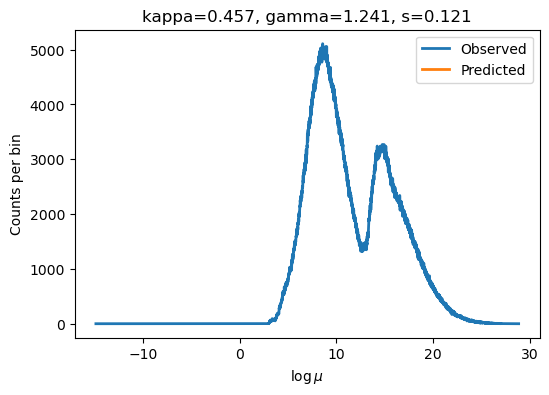

nan 4000675.510255552


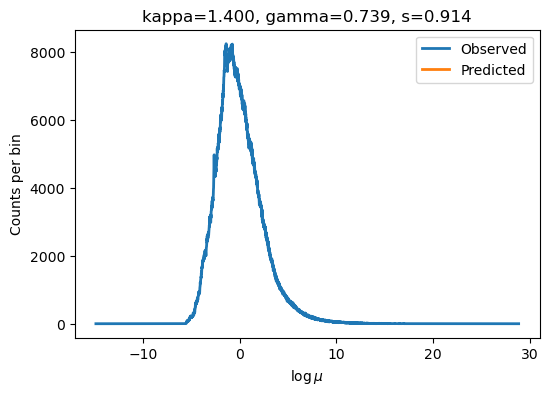

nan 4000270.486792034


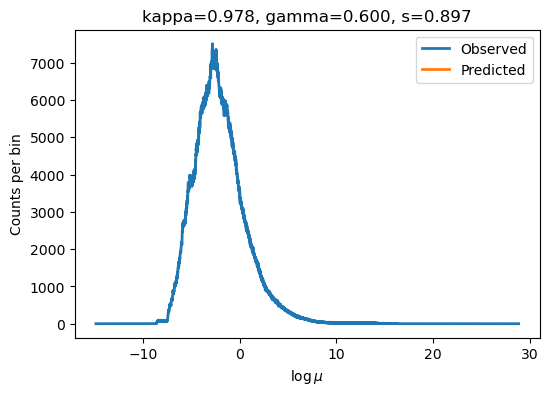

In [199]:
import matplotlib.pyplot as plt

# 随机选 3 个样本
test_idx = np.random.choice(len(dataset), 3, replace=False)

for i in test_idx:
    eta = dataset[i]['eta']
    y_true = dataset[i]['y']
    cnt_true = dataset[i]['cnt']
    dL = dataset[i]['dL']
    
    # 预测
    pdf_log, _ = evaluate_pdf(model, eta, eta_mean, eta_std, y_true)
    # 转成计数的尺度：pdf * 总数 * bin宽度
    cnt_pred = pdf_log * cnt_true.sum() * dL

    print(cnt_pred.sum(), cnt_true.sum())
    
    plt.figure(figsize=(6,4))
    plt.plot(y_true, cnt_true, label='Observed', lw=2)
    plt.plot(y_true, cnt_pred, label='Predicted', lw=2)
    plt.xlabel(r'$\log \mu$')
    plt.ylabel('Counts per bin')
    plt.legend()
    plt.title(f'kappa={eta[0]:.3f}, gamma={eta[1]:.3f}, s={eta[2]:.3f}')
    plt.show()


success: False STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT
weights = [0.96042581 0.00828202 0.00785133 0.02344084]
calib (b0,b1,b2) = (0.6126227210393371, 0.020411022521678753, -0.014948739050202425)


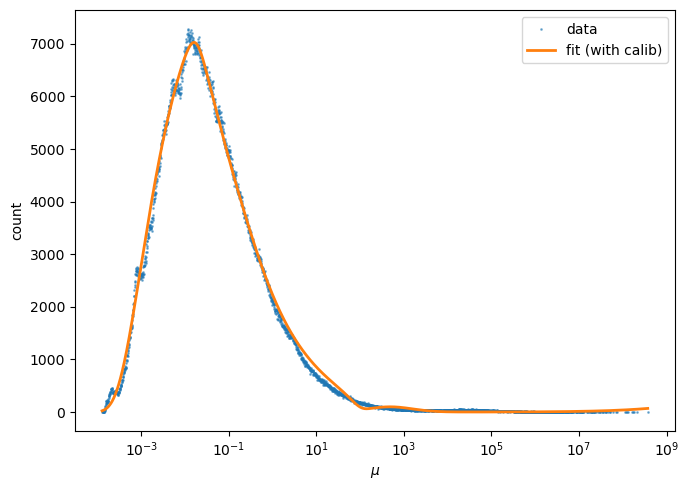

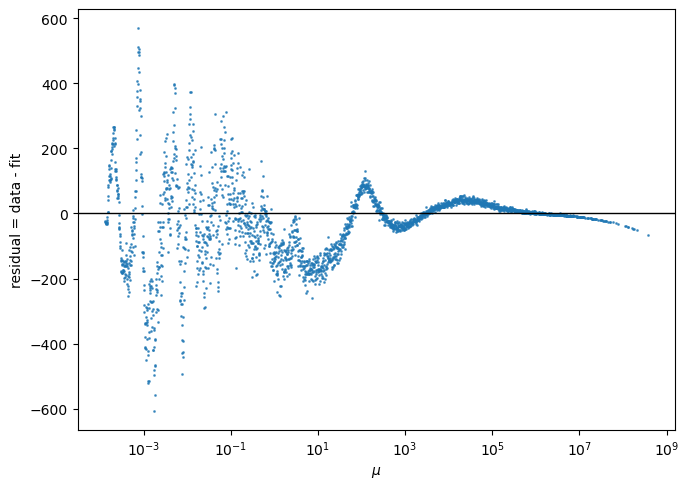

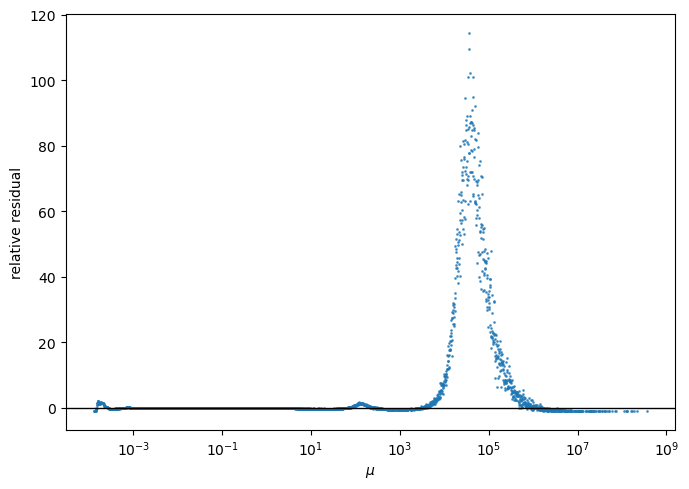

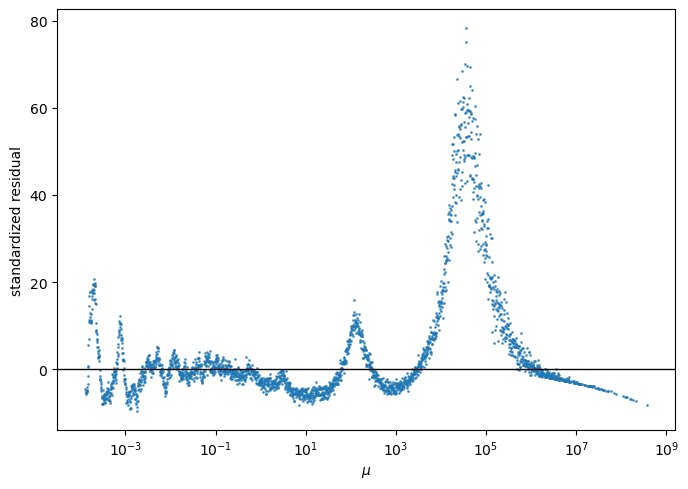

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gammaln, erf, logsumexp

# ------------ 配置 ------------
RID = "r0428"
NPZ = f"data_cache/hists/{RID}.npz"
dL = 0.01

USE_BUMP1 = True
USE_BUMP2 = True
USE_FLAT  = True

# 加权（可按需调）
PEAK_RANGE = (2e-3, 2e-1); PEAK_W = 10.0
MID_RANGE  = (1e2, 1e4) ;  MID_W  =  6.0
LOW_RANGE  = (1e-5, 5e-4); LOW_W  =  0.5
TAIL_RANGE = (1.0, 1e9) ;  TAIL_W =  0.7

# 校正项 g(x)=exp(b0 + b1 x + b2 x^2) 的正则强度（越大越“更平”）
CALIB_L2 = 1.0    # 对 b1,b2 的 L2 惩罚系数（可调 0.1~10）
USE_CALIB = True  # 打开/关闭校正

# ------------ 读数据 ------------
d = np.load(NPZ)
mu  = d["mu_log"].astype(float)
cnt = d["cnt_log"].astype(float)
m = (mu>0) & np.isfinite(cnt) & (cnt>=0)
mu, cnt = mu[m], cnt[m]
dmu = mu * (np.exp(dL) - 1.0)
Ntot = cnt.sum()
x = np.log(mu)  # 方便校正多项式

# ------------ 形状函数 ------------
def shape_sbpl2(mu, a_low, a_high, mub, q, mu0, muc, kt):
    mu = np.clip(mu, 1e-300, None)
    base = mu**(-a_low)
    br   = (1.0 + (mu/np.clip(mub,1e-30,None))**q) ** (-(a_high - a_low)/q)
    low  = np.exp(-mu0 / mu)
    high = np.exp(- (mu/np.clip(muc,1e-30,None))**np.clip(kt, 0.5, 8.0))
    return base * br * low * high

def shape_log_skew_normal(mu, m, s, skew):
    mu = np.clip(mu, 1e-300, None)
    s  = np.clip(s, 1e-9, None)
    z  = (np.log(mu) - m) / s
    phi = np.exp(-0.5*z*z) / np.sqrt(2*np.pi)
    Phi = 0.5 * (1.0 + erf(skew * z / np.sqrt(2.0)))
    return 2.0 * phi * Phi / (mu * s)

def shape_flat(mu):
    return np.ones_like(mu)

def to_density(shape_vals, dmu_local):
    Z = np.sum(shape_vals * dmu_local)
    return shape_vals / max(Z, 1e-300)

# ------------ 期望计数（混合 + 校正） ------------
def expected_counts(theta, mu_arr=mu, dmu_arr=dmu, x_arr=x):
    """
    参数顺序：
    base:   a_low, a_high, mub, mu0, muc, kt
    bump1:  m1, s1, skew1         [若 USE_BUMP1]
    bump2:  m2, s2, skew2         [若 USE_BUMP2]
    logits: u_base, u_b1, u_b2    [按启用情况截取]
    scale:  logN
    calib:  b0, b1, b2            [若 USE_CALIB]
    """
    idx = 0
    a_low,a_high,mub,mu0,muc,kt = theta[idx:idx+6]; idx += 6
    q = 5.0

    p_base = to_density(shape_sbpl2(mu_arr, a_low,a_high,mub,q,mu0,muc,kt), dmu_arr)
    comps = [p_base]
    ulist = []

    if USE_BUMP1:
        m1,s1,sk1 = theta[idx:idx+3]; idx += 3
        s1 = np.clip(s1, 0.05, 1.2)
        p_b1 = to_density(shape_log_skew_normal(mu_arr, m1,s1,sk1), dmu_arr)
        comps.append(p_b1)

    if USE_BUMP2:
        m2,s2,sk2 = theta[idx:idx+3]; idx += 3
        s2 = np.clip(s2, 0.05, 1.2)
        p_b2 = to_density(shape_log_skew_normal(mu_arr, m2,s2,sk2), dmu_arr)
        comps.append(p_b2)

    # 权重 logits
    u_base = theta[idx]; idx += 1
    ulist.append(u_base)
    if USE_BUMP1: ulist.append(theta[idx]); idx += 1
    if USE_BUMP2: ulist.append(theta[idx]); idx += 1

    # flat 分量
    if USE_FLAT:
        p_flat = to_density(shape_flat(mu_arr), dmu_arr)
        comps.append(p_flat)
        ulist.append(0.0)

    u = np.array(ulist, float)
    w = np.exp(u - logsumexp(u))

    pmix = np.zeros_like(mu_arr)
    for wi, pi in zip(w, comps):
        pmix += wi * pi

    logN = theta[idx]; idx += 1
    Nscale = np.exp(logN)

    # 校正 g(x)=exp(b0 + b1 x + b2 x^2)
    if USE_CALIB:
        b0, b1, b2 = theta[idx:idx+3]; idx += 3
        g = np.exp(b0 + b1 * x_arr + b2 * x_arr**2)
    else:
        g = 1.0

    lam = np.clip(Nscale * pmix * g * dmu_arr, 1e-30, None)

    # 返回额外信息以便 nll 做正则
    extra = {'g_params': (b0, b1, b2)} if USE_CALIB else None
    return lam, w, extra

# ------------ 加权 Poisson NLL + 校正正则 ------------
weights = np.ones_like(mu, float)
weights[(mu>=PEAK_RANGE[0]) & (mu<=PEAK_RANGE[1])] *= PEAK_W
weights[(mu>=MID_RANGE[0])  & (mu<=MID_RANGE[1])]  *= MID_W
weights[(mu>=LOW_RANGE[0])  & (mu<=LOW_RANGE[1])]  *= LOW_W
weights[(mu>=TAIL_RANGE[0]) & (mu<=TAIL_RANGE[1])] *= TAIL_W

def nll(theta):
    lam, _, extra = expected_counts(theta)
    loss = np.sum(weights * (lam - cnt*np.log(lam) + gammaln(cnt + 1.0)))
    # 对校正的斜率和二次项做L2正则，避免g(x)吸收真实结构
    if USE_CALIB and CALIB_L2 > 0:
        _, b1, b2 = extra['g_params']
        loss += CALIB_L2 * (b1*b1 + b2*b2)
    return loss

# ------------ 初值与边界 ------------
theta0 = [
    # base
    0.6, 2.2, 5e-3, 1e-3, 50.0, 2.5,
]
bounds = [
    (0.1,3.0), (0.8,6.0), (1e-4,1.0), (1e-5,1e-1), (1e-1,1e4), (0.8,6.0),
]

if USE_BUMP1:
    theta0 += [-2.7, 0.35, 2.0]              # m1, s1, skew1
    bounds += [(-12,12), (0.05,1.2), (-8.0,8.0)]
if USE_BUMP2:
    theta0 += [np.log(5e2), 0.5, 0.0]        # m2, s2, skew2
    bounds += [(np.log(1e2), np.log(1e4)), (0.05,1.2), (-8.0,8.0)]

# 权重 logits & 幅度
theta0 += [2.0] + ([0.0] if USE_BUMP1 else []) + ([0.0] if USE_BUMP2 else [])
bounds += [(-8,8)] + ([(-8,8)] if USE_BUMP1 else []) + ([(-8,8)] if USE_BUMP2 else [])
theta0 += [np.log(max(Ntot,1.0))]
bounds += [(np.log(1e-2), np.log(1e12))]

# 校正参数初值与边界
if USE_CALIB:
    theta0 += [0.0, 0.0, 0.0]    # b0,b1,b2
    bounds += [(-2.0, 2.0), (-1.0, 1.0), (-0.5, 0.5)]

theta0 = np.array(theta0, float)

# ------------ 拟合 ------------
res = minimize(nll, theta0, bounds=bounds, method="L-BFGS-B")
print("success:", res.success, res.message)
lam_fit, w, extra = expected_counts(res.x)
print("weights =", w)
if USE_CALIB:
    print("calib (b0,b1,b2) =", extra['g_params'])

# ------------ 画拟合 ------------
plt.figure(figsize=(7,5))
plt.plot(mu, cnt, '.', ms=2, alpha=0.5, label='data')
plt.plot(mu, lam_fit, '-', lw=2, label='fit (with calib)')
plt.xscale('log'); plt.xlabel(r'$\mu$'); plt.ylabel('count')
plt.legend(); plt.tight_layout(); plt.show()

# ------------ 残差 ------------
res_abs = cnt - lam_fit
res_rel = res_abs / np.clip(lam_fit, 1e-12, None)
res_std = res_abs / np.sqrt(np.clip(lam_fit, 1e-12, None))

for title, arr in [
    ("residual = data - fit", res_abs),
    ("relative residual",     res_rel),
    ("standardized residual", res_std),
]:
    plt.figure(figsize=(7,5))
    plt.plot(mu, arr, '.', ms=2, alpha=0.7)
    plt.axhline(0, color='k', lw=1)
    plt.xscale('log'); plt.xlabel(r'$\mu$'); plt.ylabel(title)
    plt.tight_layout(); plt.show()

# ------------ 预测接口 ------------
def predict(mu_list, return_pdf=False):
    mu_new = np.asarray(mu_list, float)
    dmu_new = mu_new * (np.exp(dL) - 1.0)
    x_new = np.log(mu_new)
    lam_new, _, extra_new = expected_counts(res.x, mu_arr=mu_new, dmu_arr=dmu_new, x_arr=x_new)
    if return_pdf:
        Nscale = np.exp(res.x[-4] if USE_CALIB else res.x[-1])  # logN 位置因是否使用校正而不同
        return np.clip(lam_new / (Nscale * dmu_new), 0, None)
    return lam_new


success: True CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
A=1.76e+05, alpha=1.328, mu0=0.00158,  C=767, ln_mu_peak=18.421, sigma_ln=4.370


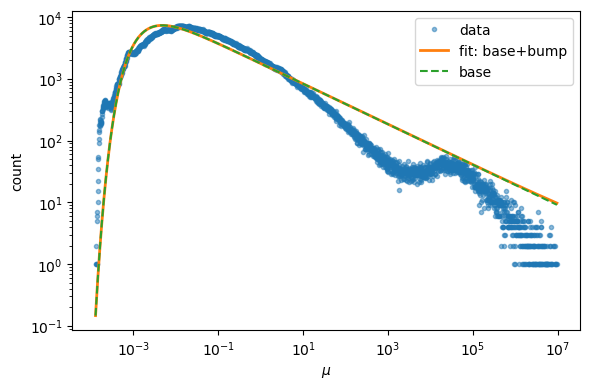

In [24]:
import numpy as np
from scipy.optimize import minimize
from scipy.special import gammaln

# 读取 r0428
data = np.load("data_cache/hists/r0428.npz")
mu = data["mu_log"].astype(float)
cnt = data["cnt_log"].astype(float)

# 只用正计数 & 合理区间（可按需要调整范围，去掉极低/极高噪声段）
mask = (cnt >= 0) & (mu > 1e-4) & (mu < 1e7)
mu, cnt = mu[mask], cnt[mask]

# log 直方图的等宽：dL=0.01 -> 每个bin的线性宽度
dL = 0.01
dmu = mu * (np.exp(dL) - 1.0)

# --- 模型：基底(幂律+低端截断) + 次峰(ln μ 上的高斯，即 lognormal 形状) ---
# 基底：A * μ^{-α} * exp(-μ0 / μ)
# 次峰：C * [ 1/(μ σ √(2π)) * exp(-(ln μ - m)^2/(2 σ^2)) ]
def model_mu_pdf(mu, A, alpha, mu0, C, m, s):
    base = A * np.power(mu, -alpha) * np.exp(-mu0 / mu)
    bump = C * (1.0 / (mu * s * np.sqrt(2*np.pi))) * np.exp(-0.5 * ((np.log(mu) - m)/s)**2)
    return base + bump  # 这是连续密度 p(μ)

# 期望计数：λ_i = p(μ_i) * Δμ_i   （总归一可能隐含在 A、C 里，不强制归一）
def expected_counts(theta):
    A, alpha, mu0, C, m, s = theta
    p = model_mu_pdf(mu, A, alpha, mu0, C, m, s)
    lam = np.clip(p, 0, np.inf) * dmu
    return lam

# Poisson 负对数似然： -∑ [ k_i log λ_i - λ_i - log(k_i!) ]
def nll(theta):
    lam = expected_counts(theta)
    # 防止 log(0)
    lam = np.clip(lam, 1e-30, np.inf)
    return np.sum(lam - cnt * np.log(lam) + gammaln(cnt + 1.0))

# 初值与边界（可根据图形微调）
theta0 = [1e4, 2.0, 1.0,   1e3, np.log(1e2), 1.0]   # [A, alpha, mu0, C, m=ln μ_peak, s]
bounds = [(1e-6, 1e12), (0.1, 10.0), (1e-6, 1e4),
          (1e-6, 1e12), (np.log(1e-6), np.log(1e8)), (0.05, 5.0)]

res = minimize(nll, theta0, bounds=bounds, method="L-BFGS-B")
print("success:", res.success, res.message)
A, alpha, mu0, C, m, s = res.x
print(f"A={A:.3g}, alpha={alpha:.3f}, mu0={mu0:.3g},  C={C:.3g}, ln_mu_peak={m:.3f}, sigma_ln={s:.3f}")

# 画拟合（对数坐标）
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(mu, cnt, '.', alpha=0.5, label='data')
lam = expected_counts(res.x)
plt.plot(mu, lam, '-', lw=2, label='fit: base+bump')

# 也可分开画出基底和次峰分量，便于诊断
base_only = (A * mu**(-alpha) * np.exp(-mu0/mu)) * dmu
bump_only = (C * (1/(mu*s*np.sqrt(2*np.pi))) * np.exp(-0.5*((np.log(mu)-m)/s)**2)) * dmu
plt.plot(mu, base_only, '--', label='base')
# plt.plot(mu, bump_only, '--', label='bump')

plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$\mu$'); plt.ylabel('count')
plt.legend()
plt.tight_layout()
plt.show()


success: True CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
alpha=1.330, mu0=0.00158,  bump: ln(mu)=2.303, sigma_ln=3.000,  weight_base=0.993


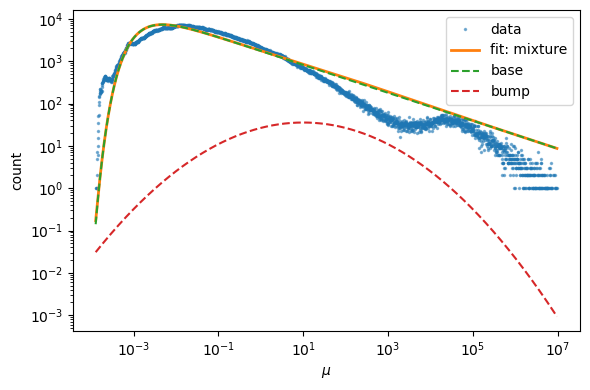

In [25]:
import numpy as np
from scipy.special import gammaln
from scipy.optimize import minimize

# === 读入 r0428 的 log 直方图 ===
d = np.load("data_cache/hists/r0428.npz")
mu = d["mu_log"].astype(float)
cnt = d["cnt_log"].astype(float)

# 选定拟合区间（按你的图调整；先别太极端）
mask = (mu > 1e-4) & (mu < 1e7)
mu, cnt = mu[mask], cnt[mask]

# log-bin 宽度
dL = 0.01
dmu = mu * (np.exp(dL) - 1.0)
Ntot = cnt.sum()

# --- 分量形状（未归一化） ---
def shape_base(mu, alpha, mu0):
    # 幂律+低端截断：μ^{-α} exp(-μ0/μ)
    return np.power(mu, -alpha) * np.exp(-mu0/np.clip(mu, 1e-300, None))

def shape_bump(mu, m, s):
    # lognormal 密度的形状部分（未归一化到离散积分=1）
    return np.exp(-0.5 * ((np.log(mu) - m)/s)**2) / np.clip(mu, 1e-300, None)

def norm_to_density(shape_vals):
    Z = np.sum(shape_vals * dmu)
    return shape_vals / max(Z, 1e-300)

# --- 期望计数 λ_i (混合密度、离散归一化) ---
def lam_expect(theta):
    # theta = [alpha, mu0, m, s, w_logit]
    alpha, mu0, m, s, w_logit = theta
    # 约束：s>0, 0<w<1 用logit
    s = max(s, 1e-3)
    w = 1.0/(1.0 + np.exp(-w_logit))  # 映射到(0,1)

    p1 = norm_to_density(shape_base(mu, alpha, mu0))            # 基底密度
    p2 = norm_to_density(shape_bump(mu, m, s) / (s*np.sqrt(2*np.pi)))  # lognormal 完整密度

    mix = w * p1 + (1.0 - w) * p2
    lam = Ntot * mix * dmu
    return np.clip(lam, 1e-30, None)

# --- Poisson 负对数似然 ---
def nll(theta):
    lam = lam_expect(theta)
    return np.sum(lam - cnt * np.log(lam) + gammaln(cnt + 1.0))

# ===== 初值与边界 =====
# 1) 基底初值：从你之前的“base-only”拟合搬过来，或给一个通用起点
alpha0, mu00 = 2.2, 0.8

# 2) 次峰初值：在一个可能的区间内找局部最大作为 m0
mask_bump = (mu > 1e2) & (mu < 1e5)  # 依图微调
if mask_bump.any():
    mu_peak0 = mu[mask_bump][np.argmax(cnt[mask_bump])]
else:
    mu_peak0 = 1e3
m0 = np.log(mu_peak0)
s0 = 0.8

# 3) 混合权重初值：主峰权重大，次峰小但非零
w0 = 0.9
wlogit0 = np.log(w0/(1-w0))

theta0 = np.array([alpha0, mu00, m0, s0, wlogit0])

# 合理的边界（L-BFGS-B 只支持 box bounds，logit 已管住w）
bounds = [(0.5, 6.0), (1e-4, 10.0), (np.log(1e1), np.log(1e6)), (0.1, 3.0), (-5.0, 5.0)]

res = minimize(nll, theta0, bounds=bounds, method="L-BFGS-B")
print("success:", res.success, res.message)
alpha, mu0, m, s, w_logit = res.x
w = 1/(1+np.exp(-w_logit))
print(f"alpha={alpha:.3f}, mu0={mu0:.3g},  bump: ln(mu)={m:.3f}, sigma_ln={s:.3f},  weight_base={w:.3f}")

# --- 画图：数据、混合拟合、分量 ---
import matplotlib.pyplot as plt
lam = lam_expect(res.x)

p1 = norm_to_density(shape_base(mu, alpha, mu0))
p2 = norm_to_density(shape_bump(mu, m, s) / (s*np.sqrt(2*np.pi)))
lam_base = Ntot * (w * p1) * dmu
lam_bump = Ntot * ((1-w) * p2) * dmu

plt.figure(figsize=(6,4))
plt.plot(mu, cnt, '.', ms=3, alpha=0.5, label='data')
plt.plot(mu, lam, '-', lw=2, label='fit: mixture')
plt.plot(mu, lam_base, '--', label='base')
plt.plot(mu, lam_bump, '--', label='bump')
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$\mu$'); plt.ylabel('count')
plt.legend(); plt.tight_layout(); plt.show()


base: a1=0.850, a2=1.399, mub=1e-05, mu0=0.00183, q=5.0
bump: ln(mu)=6.215, sigma_ln=1.500
weights: base=0.998, bump=0.000, flat=0.002


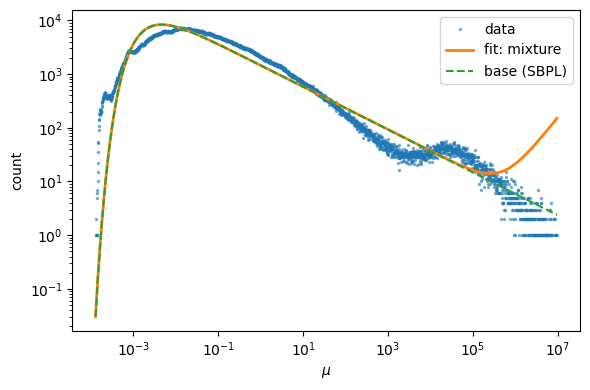

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter1d
from scipy.special import logsumexp, gammaln

# === 读取 r0428 的 log 直方图数据 ===
d = np.load("data_cache/hists/r0428.npz")
mu = d["mu_log"].astype(float)
cnt = d["cnt_log"].astype(float)

# 过滤数据范围
mask_all = (mu > 1e-4) & (mu < 1e7) & np.isfinite(cnt)
mu = mu[mask_all]
cnt = cnt[mask_all]

# log-bin 宽度和 bin size
dL = 0.01
dmu = mu * (np.exp(dL) - 1.0)
Ntot = cnt.sum()

# ===== 模型形状 =====
def sbpl_shape(mu, a1, a2, mub, q, mu0):
    """Smooth broken power-law + low-end cutoff."""
    x = np.power(mu, -a1)
    br = np.power(1.0 + (mu / np.clip(mub, 1e-30, None))**q, -(a2 - a1)/q)
    low = np.exp(-mu0 / np.clip(mu, 1e-30, None))
    return x * br * low

def bump_shape(mu, m, s):
    """Lognormal bump."""
    return np.exp(-0.5*((np.log(mu)-m)/s)**2) / np.clip(mu,1e-300,None) / (s*np.sqrt(2*np.pi))

def flat_shape(mu):
    """Flat density."""
    return np.ones_like(mu)

def to_density(shape_vals, dmu_local):
    """归一化成密度（离散归一化）"""
    Z = np.sum(shape_vals * dmu_local)
    return shape_vals / max(Z, 1e-300)

# ===== Step 1: 先拟基底（避开次峰窗口） =====
mask_base = ((mu > 1e-4) & (mu < 30)) | ((mu > 1e5) & (mu < 1e7))
mu_b = mu[mask_base]
cnt_b = cnt[mask_base]
dmu_b = dmu[mask_base]

def lam_base(theta):
    a1, a2, mub, mu0 = theta
    q = 5.0
    shape = sbpl_shape(mu_b, a1, a2, mub, q, mu0)
    p = to_density(shape, dmu_b)
    return np.clip(Ntot * p * dmu_b, 1e-30, None)

def nll_base(theta):
    lam = lam_base(theta)
    return np.sum(lam - cnt_b*np.log(lam) + gammaln(cnt_b+1.0))

theta0_base = [2.0, 2.6, 1e-2, 0.8]
bnds_base = [(0.2,6.0),(0.5,8.0),(1e-5,1e2),(1e-4,10.0)]
res_base = minimize(nll_base, theta0_base, bounds=bnds_base, method="L-BFGS-B")
a1, a2, mub, mu0 = res_base.x
q_fixed = 5.0

# ===== Step 2: 残差找次峰初值 =====
p_base_full = to_density(sbpl_shape(mu, a1,a2,mub,q_fixed,mu0), dmu)
lam_base_full = Ntot * p_base_full * dmu
resid = cnt - lam_base_full
r_smooth = gaussian_filter1d(resid, sigma=10)
j = np.argmax(r_smooth)
m0 = np.log(mu[j])
s0 = 0.6

# ===== Step 3: 联合拟合三分量（加权 + 次峰中心范围限制） =====
# 次峰锁定范围（比如 μ ~ 10^3 左右）
bump_mu_min = np.log(5e2)
bump_mu_max = np.log(2e3)

# 次峰区加权
mask_peak = (mu > 1e2) & (mu < 1e4)
weights = np.ones_like(mu)
weights[mask_peak] = 10.0  # 次峰区权重加大

def lam_mix(theta):
    a1,a2,mub,mu0, m,s, u1,u2 = theta
    s = np.clip(s, 0.15, 1.5)
    q = q_fixed

    shape1 = sbpl_shape(mu, a1,a2,mub,q,mu0)
    shape2 = bump_shape(mu, m, s)
    shape3 = flat_shape(mu)

    p1 = to_density(shape1, dmu)
    p2 = to_density(shape2, dmu)
    p3 = to_density(shape3, dmu)

    u = np.array([u1,u2,0.0])
    w = np.exp(u - logsumexp(u))
    w1,w2,w3 = w[0], w[1], w[2]

    p = w1*p1 + w2*p2 + w3*p3
    lam = np.clip(Ntot * p * dmu, 1e-30, None)
    return lam, (w1,w2,w3)

def nll_mix(theta):
    lam, (w1,w2,w3) = lam_mix(theta)
    reg = 0.001 * ((max(0.0, 0.02 - w2))**2)  # 防止 bump 权重塌缩
    return np.sum(weights * (lam - cnt*np.log(lam) + gammaln(cnt+1.0))) + reg

theta0 = [a1,a2,mub,mu0, m0,s0,  2.0, -1.0]
bnds = [(0.2,6.0),(0.5,8.0),(1e-5,1e2),(1e-4,10.0),
        (bump_mu_min, bump_mu_max), (0.15,1.5),
        (-6.0,6.0), (-6.0,6.0)]
res = minimize(nll_mix, theta0, bounds=bnds, method="L-BFGS-B")
a1,a2,mub,mu0, m,s, u1,u2 = res.x
lam, (w1,w2,w3) = lam_mix(res.x)

print(f"base: a1={a1:.3f}, a2={a2:.3f}, mub={mub:.3g}, mu0={mu0:.3g}, q={q_fixed}")
print(f"bump: ln(mu)={m:.3f}, sigma_ln={s:.3f}")
print(f"weights: base={w1:.3f}, bump={w2:.3f}, flat={w3:.3f}")

# ===== 绘图 =====
p1 = to_density(sbpl_shape(mu, a1,a2,mub,q_fixed,mu0), dmu)
p2 = to_density(bump_shape(mu, m, s), dmu)
p3 = to_density(flat_shape(mu), dmu)
lam1 = Ntot * w1 * p1 * dmu
lam2 = Ntot * w2 * p2 * dmu
lam3 = Ntot * w3 * p3 * dmu

plt.figure(figsize=(6,4))
plt.plot(mu, cnt, '.', ms=3, alpha=0.5, label='data')
plt.plot(mu, lam, '-', lw=2, label='fit: mixture')
plt.plot(mu, lam1, '--', label='base (SBPL)')
# plt.plot(mu, lam2, '--', label='bump (lognormal)')
# plt.plot(mu, lam3, '--', label='flat')
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$\mu$'); plt.ylabel('count')
plt.legend(); plt.tight_layout(); plt.show()


In [54]:
import numpy as np
from scipy.interpolate import UnivariateSpline

class MuCurveFitter:
    def __init__(self, mu_train, count_train, smooth_factor=None):
        """
        mu_train: 拟合用 μ 列表
        count_train: 拟合用 count 列表
        smooth_factor: 平滑因子（越大越光滑，None 表示自动）
        """
        self.mu_train = np.array(mu_train, dtype=float)
        self.count_train = np.array(count_train, dtype=float)
        
        # 在 log(mu)-log(count) 空间做拟合，避免数量级问题
        self.spline = UnivariateSpline(
            np.log(self.mu_train), np.log(self.count_train),
            s=smooth_factor
        )
    
    def predict(self, mu_list):
        """
        mu_list: 新的 μ 值列表
        返回: 预测的 count 值
        """
        mu_arr = np.array(mu_list, dtype=float)
        log_cnt_pred = self.spline(np.log(mu_arr))
        return np.exp(log_cnt_pred)

# ===== 用法示例 =====
# if __name__ == "__main__":
    # 训练数据
mu = d["mu_log"].astype(float)
cnt = d["cnt_log"].astype(float)
    
fitter = MuCurveFitter(mu,  cnt, smooth_factor=0.5)
    
# 新数据预测
mu_new = np.logspace(-3, 5, 500)
pred = fitter.predict(mu_new)
for m, c in zip(mu_new, pred):
    print((m,c))


(0.001, 2601.3965564223504)
(0.0010376050197669117, 2597.071890582734)
(0.0010766241770454933, 2575.8254880597565)
(0.0011171106505048242, 2691.780514881172)
(0.0011591196185988858, 2775.299137014384)
(0.001202708334768512, 2901.9300913483785)
(0.0012479362054713115, 2772.2941559667465)
(0.001294864871145905, 2899.102735923042)
(0.0013435582902208262, 3106.5605376749068)
(0.0013940828262825786, 3324.3852465893488)
(0.0014465073385216472, 3353.3927976944433)
(0.0015009032755797366, 3444.8418552637563)
(0.0015573447729261352, 3528.9541649573207)
(0.001615908753895919, 3530.7116184681654)
(0.0016766750345276991, 3530.8793451310203)
(0.0017397264323438008, 3581.4413215925783)
(0.0018051488792211082, 3592.617790147858)
(0.0018730315385064365, 3823.459398874699)
(0.0019434669265360202, 4030.425838317438)
(0.0020165510387247466, 4116.637260533574)
(0.002092383480396977, 4153.534042957037)
(0.002171067602537265, 4349.915420283953)
(0.0022527106426459805, 4404.432213970807)
(0.00233742387089181

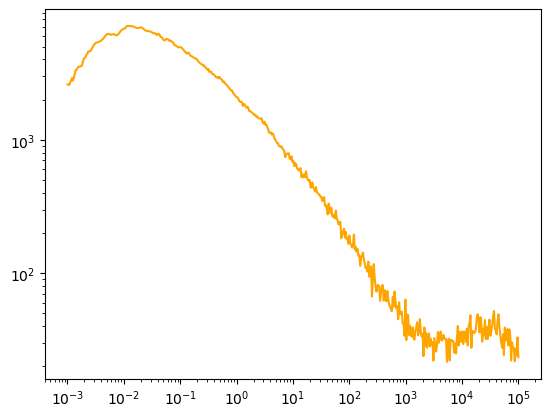

In [57]:
plt.plot(mu_new, pred, label='预测', color='orange')
plt.xscale('log')
plt.yscale('log')

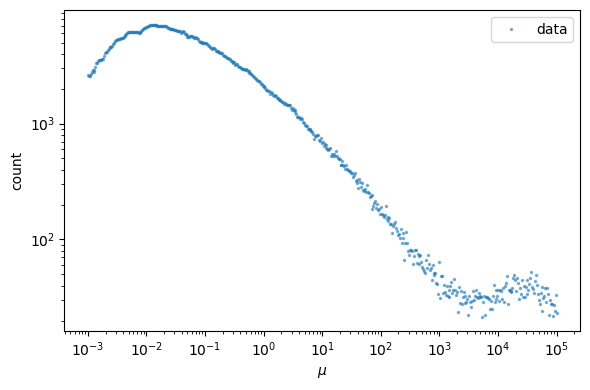

In [56]:
plt.figure(figsize=(6,4))
plt.plot(mu_new, pred, '.', ms=3, alpha=0.5, label='data')

# plt.plot(mu, lam2, '--', label='bump (lognormal)')
# plt.plot(mu, lam3, '--', label='flat')
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$\mu$'); plt.ylabel('count')
plt.legend(); plt.tight_layout(); plt.show()

In [61]:
import numpy as np
from scipy.interpolate import UnivariateSpline

class LogMuProbSmoother:
    def __init__(self, mu_train, prob_train, smooth_factor=None):
        """
        mu_train: μ 列表（正数）
        prob_train: 概率密度列表
        smooth_factor: 平滑因子，越大曲线越光滑
        """
        mu_train = np.array(mu_train, dtype=float)
        prob_train = np.array(prob_train, dtype=float)
        
        self.logmu_train = np.log(mu_train)
        self.prob_train = prob_train
        
        # 直接在 logμ–prob 空间拟合
        self.spline = UnivariateSpline(
            self.logmu_train, self.prob_train, s=smooth_factor
        )
    
    def predict(self, mu_list):
        """
        mu_list: 新 μ 列表
        返回: 对应的平滑 prob 值
        """
        mu_arr = np.array(mu_list, dtype=float)
        return self.spline(np.log(mu_arr))

# ===== 用法示例 =====
if __name__ == "__main__":
    # 假设你的数据（这里只示意 5 个点）
    # mu_train = [1e-2, 1.26e-2, 1.6e-2, 2.02e-2, 2.56e-2]
    # prob_train = [0.033, 0.035, 0.036, 0.038, 0.041]

    mu_train = d["mu_log"].astype(float)
    cnt = d["cnt_log"].astype(float)

    smoother = LogMuProbSmoother(mu, cnt, smooth_factor=1e-4)

    # 新数据预测
    mu_new = [1e-2, 1.5e-2, 2e-2]
    pred = smoother.predict(mu_new)
    for m, p in zip(mu_new, pred):
        print(f"{m:.6e} -> {p:.6f}")


1.000000e-02 -> 6616.042640
1.500000e-02 -> 7053.996613
2.000000e-02 -> 7090.602755
